## Libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import sys
import lz4.frame
import random as rn
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from pathlib import Path
from settings import (SPEED_DATA_PATH, 
                      WIND_DATA_PATH, GEO_PATH)
from compress.sprintz_encode import compress_sprintz, get_sprintz_memory, decompress_sprintz
from compress.bypass import spatial_clustering, geo_sort, get_corr_lists
from compress.general_functions import get_memory_init, get_float_bytes
from compress.xor_encode import xor_compress_df, get_xor_memory_df, decompress_xor, decompress_xor_df
#from compress.xor_decode import decompress_xor, decompress_xor_df
from compress.lz4_encode import LZ4_compress_df, get_lz4_memory, LZ4_decompress_df
from compress.spatial_lz4 import spatial_clustering_PCA_LZ4, spatial_lz4_decompress
from compress.spatial_xor import spatial_clustering_xor, spatial_XOR_decompress
from compress.spatial_sprintz import spatial_clustering_sprintz, spatial_sprintz_decompress
import seaborn as sns
warnings.filterwarnings("ignore")

## Params

In [2]:
table_params = [{
                'selector': 'caption',
                'props': [
                    ('color', 'Blue'),
                    ('font-size', '16pt'),
                    ('font-weight', 'bold'),
                    ('text-align', 'center'),
                    ('caption-side', 'top'),
                    ('padding', '10px')
                ]
            },
            {
                'selector': 'th',
                'props': [('font-size', '14pt')]
            }]

## Data

In [3]:
# int time series
speed_init = pd.read_csv(SPEED_DATA_PATH, parse_dates=[0], index_col=[0])# –¥–∞–Ω–Ω—ã–µ –∑–∞–ø–æ–ª–Ω–µ–Ω–Ω–æ—Å—Ç–∏ –¥–æ—Ä–æ–≥
speed_init.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2015-08-31 18:22:00 to 2015-09-17 16:24:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   2500 non-null   int64
dtypes: int64(1)
memory usage: 39.1 KB


In [4]:
speed_init['index'] = np.arange(speed_init.shape[0])
sensor_data = {}

for i in range(5):
    sensor_data[f'sensor_{i+1}'] = speed_init.loc[speed_init['index'] % 5 == i,
                                             ['value']]['value'].to_list()

df_speed = pd.DataFrame(sensor_data)
print('DataFrame shape:', df_speed.shape)
df_speed.head()

DataFrame shape: (500, 5)


sensor_1  sensor_2  sensor_3  sensor_4  sensor_5
0        90        80        84        94        90
1        91        62        96        75        84
2        86        93        69        88        71
3        74        68        88        71        87
4        82        68        73        69        57

In [5]:
df_speed.describe()

sensor_1    sensor_2    sensor_3    sensor_4    sensor_5
count  500.000000  500.000000  500.000000  500.000000  500.000000
mean    82.126000   81.538000   81.862000   81.786000   82.222000
std      8.404963    9.247897    8.155488    8.913085    8.983659
min     43.000000   28.000000   53.000000   29.000000   20.000000
25%     77.000000   76.000000   77.000000   76.000000   77.000000
50%     83.000000   82.000000   82.000000   82.000000   83.000000
75%     87.000000   88.000000   87.000000   88.000000   88.000000
max    109.000000  103.000000  106.000000  106.000000  105.000000

In [6]:
corr_speed = df_speed.corr()
styled_corr_speed = corr_speed.style.set_caption("Correlation matrix of Emhires Dataset") \
                                  .background_gradient(cmap='coolwarm') \
                                  .set_properties(**{'font-size': '14pt'}) \
                                  .set_table_styles(table_params)

# –û—Ç–æ–±—Ä–∞–∂–µ–Ω–∏–µ –º–∞—Ç—Ä–∏—Ü—ã –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏
display(styled_corr_speed)

In [7]:
df_wind_init = pd.read_csv(WIND_DATA_PATH)
df_wind_init.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262968 entries, 0 to 262967
Data columns (total 29 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AT      262968 non-null  float64
 1   BE      262968 non-null  float64
 2   BG      262968 non-null  float64
 3   CH      262968 non-null  float64
 4   CY      262968 non-null  int64  
 5   CZ      262968 non-null  float64
 6   DE      262968 non-null  float64
 7   DK      262968 non-null  float64
 8   EE      262968 non-null  float64
 9   ES      262968 non-null  float64
 10  FI      262968 non-null  float64
 11  FR      262968 non-null  float64
 12  EL      262968 non-null  float64
 13  HR      262968 non-null  float64
 14  HU      262968 non-null  float64
 15  IE      262968 non-null  float64
 16  IT      262968 non-null  float64
 17  LT      262968 non-null  float64
 18  LU      262968 non-null  float64
 19  LV      262968 non-null  float64
 20  NL      262968 non-null  float64
 21  NO      26

–í–æ–∑—å–º–µ–º –¥–∞–Ω–Ω—ã–µ –æ –ø–µ—Ä–≤—ã—Ö —à–µ—Å—Ç–∏ –≤–µ—Ç—Ä–µ–Ω–Ω—ã—Ö –≤—ã—à–µ–∫.

In [8]:
df_wind = df_wind_init[['AT', 'BE', 'BG', 'CH', 'CZ', 'DE']]
df_wind = df_wind.head(10000)

–í–∏–¥–∏–º, —á—Ç–æ –¥–∞–Ω–Ω—ã–µ –Ω–µ–Ω—É–ª–µ–≤—ã–µ —á–µ—Ä–µ–∑ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω—ã–µ –ø—Ä–æ–º–µ–∂—É—Ç–∫–∏ –≤—Ä–µ–º–µ–Ω–∏. –≠—Ç–æ —Å–≤—è–∑–∞–Ω–æ —Å —Ç–µ–º, —á—Ç–æ –æ—Ç—Å—É—Ç—Å—Ç–≤—É–µ—Ç –Ω–µ–ø—Ä–µ—Ä—ã–≤–Ω–æ—Å—Ç—å –∑–∞–º–µ—Ä–æ–≤ –¥–∞–Ω–Ω—ã—Ö. –û—Å—Ç–∞–≤–∏–º —Ç–æ–ª—å–∫–æ —Ç–µ —Å—Ç—Ä–æ–∫–∏, –≥–¥–µ –µ—Å—Ç—å —Ö–æ—Ç—è –±—ã –æ–¥–Ω–æ –Ω–µ–Ω—É–ª–µ–≤–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ.

In [9]:
# Ensure the correct columns are used
df_wind = df_wind.loc[(
    df_wind[['AT', 'BE', 'BG', 'CH', 'CZ', 'DE']] != 0).any(axis=1)].reset_index(drop=True)
df_wind.columns = [f'sensor_{i}' for i in range(df_wind.shape[1])]
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5371 entries, 0 to 5370
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sensor_0  5371 non-null   float64
 1   sensor_1  5371 non-null   float64
 2   sensor_2  5371 non-null   float64
 3   sensor_3  5371 non-null   float64
 4   sensor_4  5371 non-null   float64
 5   sensor_5  5371 non-null   float64
dtypes: float64(6)
memory usage: 251.9 KB


## Data analisys

In [10]:
corr_wind = df_wind.corr()
styled_corr_wind = corr_wind.style.set_caption("Correlation matrix of Emhires Dataset") \
                                  .background_gradient(cmap='coolwarm') \
                                  .set_properties(**{'font-size': '14pt'}) \
                                  .set_table_styles(table_params)

# –û—Ç–æ–±—Ä–∞–∂–µ–Ω–∏–µ –º–∞—Ç—Ä–∏—Ü—ã –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏
display(styled_corr_wind)

### –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ

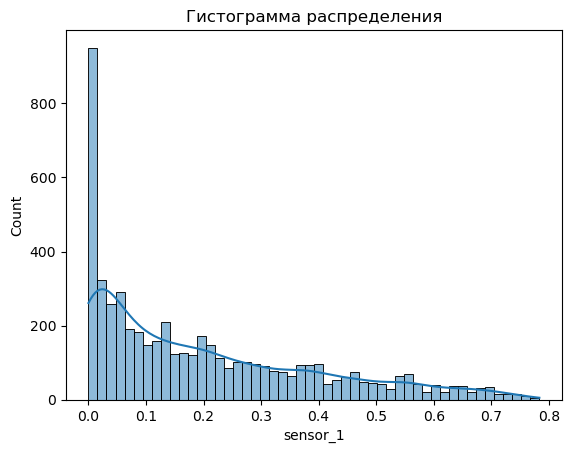

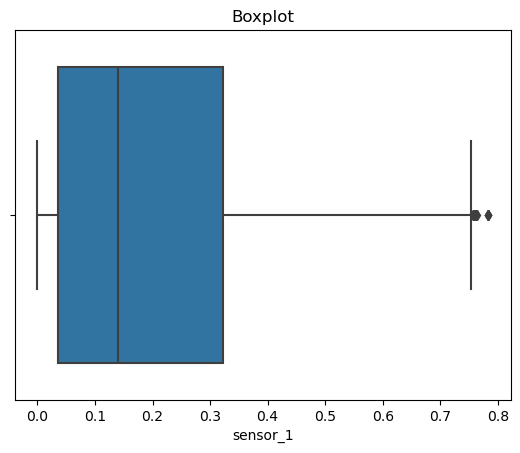

In [11]:
# –ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ + KDE
data = df_wind['sensor_1']
sns.histplot(data, kde=True, bins=50)
plt.title("–ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è")
plt.show()

# Boxplot
sns.boxplot(x=data)
plt.title("Boxplot")
plt.show()

In [12]:
from scipy.stats import skew, kurtosis

skewness = skew(data)
kurt = kurtosis(data)

print(f"–ê—Å–∏–º–º–µ—Ç—Ä–∏—è: {skewness:.2f}")
print(f"–≠–∫—Å—Ü–µ—Å—Å: {kurt:.2f}")

–ê—Å–∏–º–º–µ—Ç—Ä–∏—è: 0.95
–≠–∫—Å—Ü–µ—Å—Å: -0.05


In [13]:
from scipy.stats import shapiro, normaltest

# –®–∞–ø–∏—Ä–æ-–£–∏–ª–∫ (—Ä–∞–±–æ—Ç–∞–µ—Ç –¥–ª—è –Ω–µ–±–æ–ª—å—à–∏—Ö –≤—ã–±–æ—Ä–æ–∫ < 5000)
stat, p = shapiro(data)
print(f"–®–∞–ø–∏—Ä–æ-–£–∏–ª–∫ p-value: {p:.5f}")

# D‚ÄôAgostino‚Äôs K-squared (–¥–ª—è –±–æ–ª—å—à–∏—Ö –≤—ã–±–æ—Ä–æ–∫)
stat, p = normaltest(data)
print(f"D‚ÄôAgostino p-value: {p:.5f}")

–®–∞–ø–∏—Ä–æ-–£–∏–ª–∫ p-value: 0.00000
D‚ÄôAgostino p-value: 0.00000


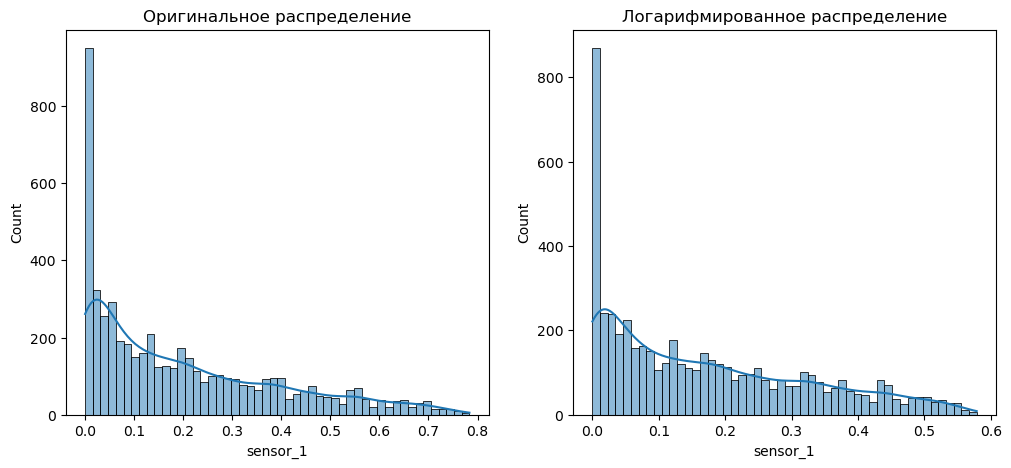

In [14]:
data_log = np.log1p(data)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data, kde=True, bins=50, ax=axes[0])
axes[0].set_title("–û—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ")

sns.histplot(data_log, kde=True, bins=50, ax=axes[1])
axes[1].set_title("–õ–æ–≥–∞—Ä–∏—Ñ–º–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ")

plt.show()

### –®—É–º

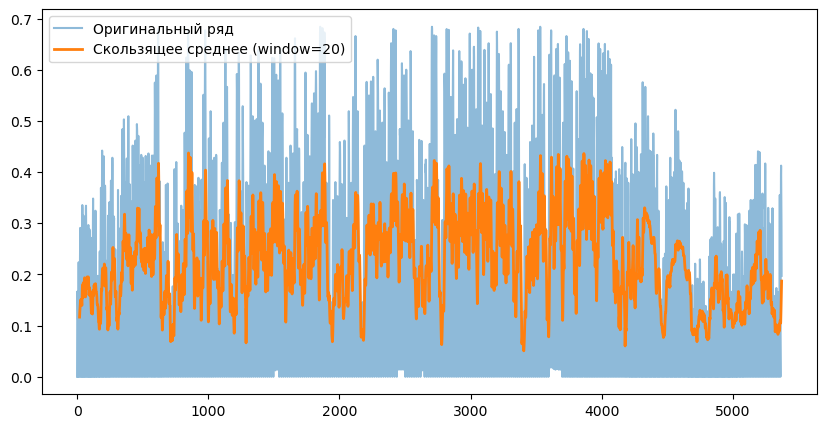

In [15]:
rolling_mean = df_wind.sensor_0.rolling(window=20).mean()

plt.figure(figsize=(10,5))
plt.plot(df_wind.sensor_0.values, label="–û—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã–π —Ä—è–¥", alpha=0.5)
plt.plot(rolling_mean, label="–°–∫–æ–ª—å–∑—è—â–µ–µ —Å—Ä–µ–¥–Ω–µ–µ (window=20)", linewidth=2)
plt.legend()
plt.show()

In [16]:
X = df_wind.sensor_0.values

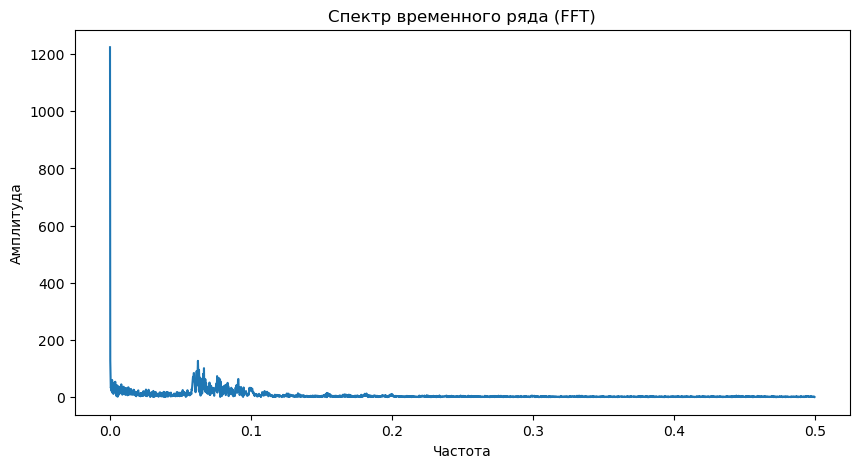

In [17]:
from scipy.fftpack import fft

X_fft = np.abs(fft(X))
freqs = np.fft.fftfreq(len(X))

plt.figure(figsize=(10,5))
plt.plot(freqs[:len(freqs)//2], X_fft[:len(X_fft)//2])
plt.title("–°–ø–µ–∫—Ç—Ä –≤—Ä–µ–º–µ–Ω–Ω–æ–≥–æ —Ä—è–¥–∞ (FFT)")
plt.xlabel("–ß–∞—Å—Ç–æ—Ç–∞")
plt.ylabel("–ê–º–ø–ª–∏—Ç—É–¥–∞")
plt.show()

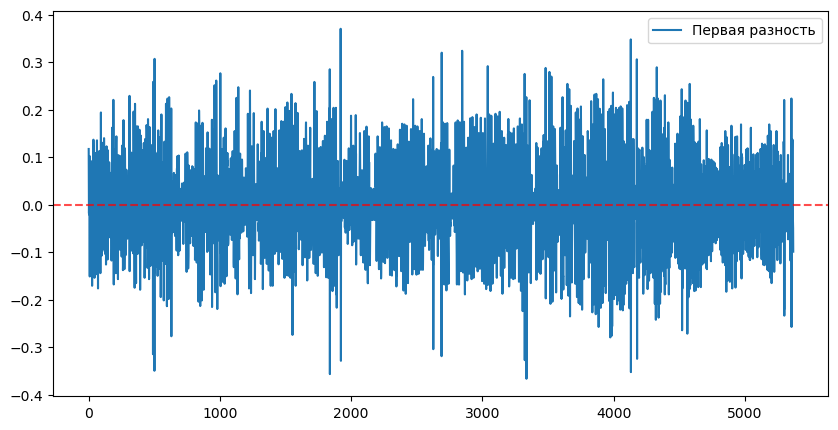

In [18]:
X_diff = np.diff(X)

plt.figure(figsize=(10,5))
plt.plot(X_diff, label="–ü–µ—Ä–≤–∞—è —Ä–∞–∑–Ω–æ—Å—Ç—å")
plt.axhline(0, color='r', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [19]:
from scipy.stats import entropy

hist, _ = np.histogram(X, bins=50)
ent = entropy(hist)

print(f"–≠–Ω—Ç—Ä–æ–ø–∏—è —Ä—è–¥–∞: {ent:.3f}")

–≠–Ω—Ç—Ä–æ–ø–∏—è —Ä—è–¥–∞: 3.685


In [20]:
import pywt

wavelet = 'haar'
coeffs = pywt.wavedec(X, wavelet, level=3)

# –û—Ü–µ–Ω–∏–º –¥–æ–ª—é —ç–Ω–µ—Ä–≥–∏–∏ –≤ –∫–∞–∂–¥–æ–º —É—Ä–æ–≤–Ω–µ —Ä–∞–∑–ª–æ–∂–µ–Ω–∏—è
energy_levels = [np.sum(np.abs(c)**2) for c in coeffs]

print("–≠–Ω–µ—Ä–≥–∏—è –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–æ–≤ –Ω–∞ –∫–∞–∂–¥–æ–º —É—Ä–æ–≤–Ω–µ —Ä–∞–∑–ª–æ–∂–µ–Ω–∏—è:", energy_levels)

–≠–Ω–µ—Ä–≥–∏—è –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–æ–≤ –Ω–∞ –∫–∞–∂–¥–æ–º —É—Ä–æ–≤–Ω–µ —Ä–∞–∑–ª–æ–∂–µ–Ω–∏—è: [356.04758554508646, 65.73701276035354, 27.73028362734523, 9.927217631002883]


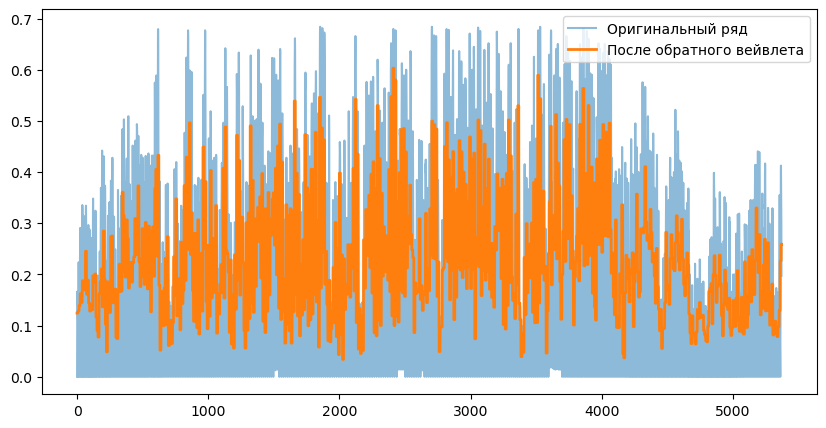

In [21]:
coeffs_filtered = [coeffs[0]] + [np.zeros_like(c) for c in coeffs[1:]]
X_restored = pywt.waverec(coeffs_filtered, wavelet)

plt.figure(figsize=(10,5))
plt.plot(X, label="–û—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã–π —Ä—è–¥", alpha=0.5)
plt.plot(X_restored, label="–ü–æ—Å–ª–µ –æ–±—Ä–∞—Ç–Ω–æ–≥–æ –≤–µ–π–≤–ª–µ—Ç–∞", linewidth=2)
plt.legend()
plt.show()

## Create or download geo_dict

In [22]:
def get_geo_dict(df):
    # make geo data
    sen_num = df.shape[1]
    x_y = []
    for i in range(sen_num):
        x_y.append([rn.uniform(.0, 6.0), rn.uniform(.0, 6.0)])
        print(f'sensor_{i}:', x_y[i])
    plt.grid(True)
    for i in range(len(x_y)):
        plt.plot(x_y[i][0], x_y[i][1], 'o', label = i)
        plt.legend(loc = 'best', fancybox = True, shadow = True)
    plt.plot(3*np.ones(300), np.arange(0, 6, 0.02))
    plt.plot(np.arange(0, 6, 0.02), 3*np.ones(300))
    geo_dict = dict(zip(df.columns, x_y))
    print(geo_dict)
    return dict(zip(df.columns, x_y))

sensor_0: [4.370713941141831, 5.747507989217377]
sensor_1: [5.397857667157046, 1.9355365729338554]
sensor_2: [1.3877396669245108, 5.1911122576427156]
sensor_3: [1.9153384919907617, 0.7532327298631094]
sensor_4: [1.26904829636013, 2.4366316299450053]
{'sensor_1': [4.370713941141831, 5.747507989217377], 'sensor_2': [5.397857667157046, 1.9355365729338554], 'sensor_3': [1.3877396669245108, 5.1911122576427156], 'sensor_4': [1.9153384919907617, 0.7532327298631094], 'sensor_5': [1.26904829636013, 2.4366316299450053]}


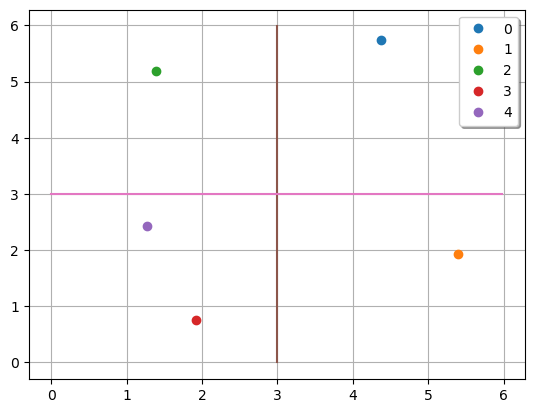

In [23]:
speed_geo_dict = get_geo_dict(df_speed)

In [24]:
display(styled_corr_wind)

In [25]:
#for best clustering
d = {'sensor_0': [1.1, 4.2],
     'sensor_1': [3.2, 1.9],
     'sensor_2': [3.8, 2.6],
     'sensor_3': [0.51, 4.9],
     'sensor_4': [1.2, 3.1],
     'sensor_5': [2.12, 3.9],
     'sensor_6': [0.8, 1.2],
     'sensor_7': [1.3, 0.9],}

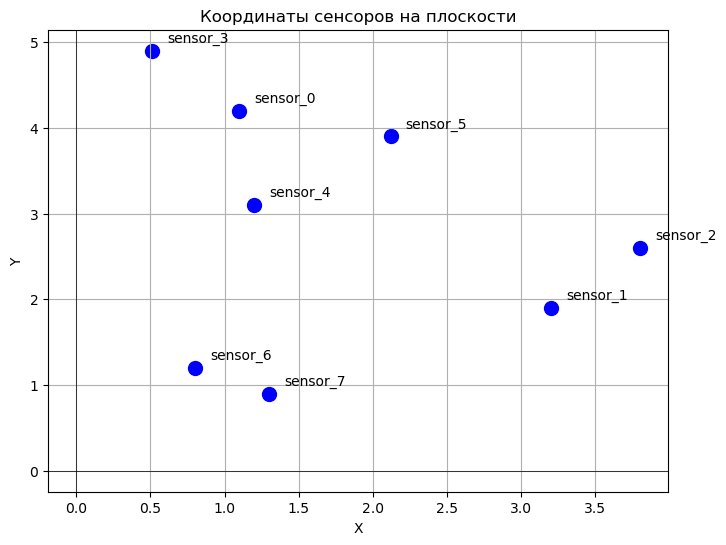

In [26]:
# –†–∞–∑–¥–µ–ª—è–µ–º –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç—ã
x_coords = [coord[0] for coord in d.values()]  # –ö–æ–æ—Ä–¥–∏–Ω–∞—Ç—ã X
y_coords = [coord[1] for coord in d.values()]  # –ö–æ–æ—Ä–¥–∏–Ω–∞—Ç—ã Y
labels = list(d.keys())  # –ú–µ—Ç–∫–∏ (–Ω–∞–∑–≤–∞–Ω–∏—è —Å–µ–Ω—Å–æ—Ä–æ–≤)

# –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–∞
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, color='blue', s=100)  # –¢–æ—á–∫–∏ –Ω–∞ –ø–ª–æ—Å–∫–æ—Å—Ç–∏

# –î–æ–±–∞–≤–ª—è–µ–º –ø–æ–¥–ø–∏—Å–∏ –∫ —Ç–æ—á–∫–∞–º
for i, label in enumerate(labels):
    plt.text(x_coords[i] + 0.1, y_coords[i] + 0.1, label, fontsize=10)

# –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –≥—Ä–∞—Ñ–∏–∫–∞
plt.title('–ö–æ–æ—Ä–¥–∏–Ω–∞—Ç—ã —Å–µ–Ω—Å–æ—Ä–æ–≤ –Ω–∞ –ø–ª–æ—Å–∫–æ—Å—Ç–∏')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)  # –õ–∏–Ω–∏—è X=0
plt.axvline(0, color='black', linewidth=0.5)  # –õ–∏–Ω–∏—è Y=0
plt.show()

In [27]:
spatial_clustering(df_wind, d)

{'sensor_0': ['sensor_0', 'sensor_3', 'sensor_5', 'sensor_4'],
 'sensor_1': ['sensor_1'],
 'sensor_2': ['sensor_2']}

sensor_0: [5.137324238092544, 2.6968292858320764]
sensor_1: [4.723149861120651, 1.5483101909593797]
sensor_2: [1.2120359191944805, 4.261181396688549]
sensor_3: [0.7575196403611213, 3.7058128876549405]
sensor_4: [1.94794872595094, 5.082292319736975]
sensor_5: [4.031323681949626, 2.67995090996953]
{'sensor_0': [5.137324238092544, 2.6968292858320764], 'sensor_1': [4.723149861120651, 1.5483101909593797], 'sensor_2': [1.2120359191944805, 4.261181396688549], 'sensor_3': [0.7575196403611213, 3.7058128876549405], 'sensor_4': [1.94794872595094, 5.082292319736975], 'sensor_5': [4.031323681949626, 2.67995090996953]}


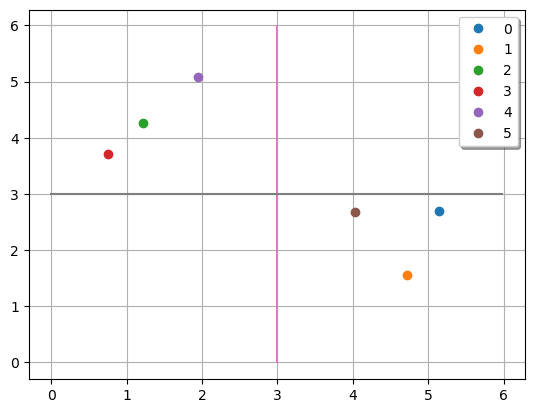

In [28]:
wind_geo_dict = get_geo_dict(df_wind)

In [29]:
print('Clusters for Emhires dataset:')
spatial_clustering(df_wind, wind_geo_dict)

Clusters for Emhires dataset:


{'sensor_0': ['sensor_0', 'sensor_5'],
 'sensor_1': ['sensor_1'],
 'sensor_2': ['sensor_2'],
 'sensor_3': ['sensor_3'],
 'sensor_4': ['sensor_4']}

In [30]:
import yaml

# Save wind_geo_dict to a YAML file
with open("wind_geo_dict_1.yaml", "w") as file:
    yaml.dump(wind_geo_dict, file)

print("wind_geo_dict has been saved as wind_geo_dict.yaml")

wind_geo_dict has been saved as wind_geo_dict.yaml


## Sprintz

In [31]:
speed_sprintz_res = compress_sprintz(df=df_speed, chunk_size=8)
speed_sprintz_res

[[['10110100', '10100000', '10101000', '10111100', '10110100'],
  '11111011011011000000010000100100101110010000100110110110000010001100011111110110001000000101001111100010101011000110101100110011101000000001110001111100101011010100001000011010010010001011101001011011001100000111011110100100111010100'],
 [['10100100', '10110100', '10111000', '1111110', '10001010'],
  '1101101101101100011110100101010001100100001011010100011101001001000110000111100001100010000011001000001011001011000111011011101110010010001101101010010001010010000000001010000111000011100110000000000001000100001111101010010001'],
 [['10101110', '10100000', '10101110', '10010110', '10010110'],
  '1101101101101100100101010100000110001000100101101010000001011100010011010010010001000100011001100010010011001010010010100101000100000100001110001110100100101011100111111000100111010010100110110011010010000110010001000101100000'],
 [['10110000', '10101010', '10111000', '10111100', '10111000'],
  '101110101110101010101000011111000100

In [32]:
df_speed

sensor_1  sensor_2  sensor_3  sensor_4  sensor_5
0          90        80        84        94        90
1          91        62        96        75        84
2          86        93        69        88        71
3          74        68        88        71        87
4          82        68        73        69        57
..        ...       ...       ...       ...       ...
495        83        88        78        97        81
496        93        77        81        74        90
497        77        80        88        84        78
498        91        83        80        77        82
499        81        89        87        82        83

[500 rows x 5 columns]

In [33]:
# Check for equals decodind and original data
decode_res = decompress_sprintz(speed_sprintz_res, chunk_size=7)
print('Check for decode:', df_speed.equals(decode_res))

Check for decode: True


In [34]:
get_memory_init(df_speed)
get_sprintz_memory(speed_sprintz_res)

–†–∞–∑–º–µ—Ä –∏—Å—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö: 17433 –±–∏—Ç
–†–∞–∑–º–µ—Ä –∏—Å—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö: 2179 –±–∞–π—Ç 

–ü–∞–º—è—Ç—å —Å–∂–∞—Ç—ã—Ö Sprintz –¥–∞–Ω–Ω—ã—Ö: 15788 –±–∏—Ç
–ü–∞–º—è—Ç—å —Å–∂–∞—Ç—ã—Ö Sprintz –¥–∞–Ω–Ω—ã—Ö: 1973 –±–∞–π—Ç 



## XOR

In [35]:
compressed_df = xor_compress_df(df_wind)
compressed_df

[['0',
  '110001011110111111110111110000100110101010110010010011100000110110010110101',
  '1000000001111011010111101110010001100000000101001001101100000001',
  '1000000000000111101101000101100000111111010011001000001011010011',
  '1000000000000111111001100011010001101101111010101011001100111101',
  '1000000000000110101011101110011010110011011100111111110101000011',
  '1000000000000010101100001111000101011000100000010110111011101010',
  '1000000001111101101001010111100101001110011011101011010001101010',
  '1000000001111111111100010010000101110101001100100011100111011001',
  '1011111111000011010101011001001001110000011011001101100001000000',
  '1011111110111010001000110001011010001110100000000010110111001101',
  '1000000001111100100111110100001011110001111101101010111011010100',
  '1000000000001010000110001110011101111010001010000110001010000000',
  '1000000000001100000000101001001010100010101101010001001010000011',
  '1000000000000001101001111110101111101100110110111010011011101001',
  

In [36]:
decompressed_df = decompress_xor_df(compressed_df)
print('Check for decode:', decompressed_df.equals(df_wind))

Check for decode: True


In [37]:
get_float_bytes(df_wind)
get_xor_memory_df(compressed_df)

–†–∞–∑–º–µ—Ä –∏—Å—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö: 2062464 –±–∏—Ç
–†–∞–∑–º–µ—Ä –∏—Å—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö: 257808 –±–∞–π—Ç 

–ü–∞–º—è—Ç—å —Å–∂–∞—Ç—ã—Ö XOR –¥–∞–Ω–Ω—ã—Ö: 1995690 –±–∏—Ç
–ü–∞–º—è—Ç—å —Å–∂–∞—Ç—ã—Ö XOR –¥–∞–Ω–Ω—ã—Ö: 249461.25 –±–∞–π—Ç


## LZ4

In [38]:
compressed_df = LZ4_compress_df(df_wind)
compressed_df

{'sensor_0': b'\x04"M\x18h@\xd8\xa7\x00\x00\x00\x00\x00\x00\x10\xf4N\x00\x00\x13\x00\x01\x00\xf0+\xb5lp\x92U\x13\xbe?\xb4\xf7d\xf2\xb1M\xc5?gu(\xcd\xe9\xf9\xc2?Z\xc6\xc2\xa0\xdd\x1f\xc5?\x19;\xb1\x13;\xb1\xc3?\xf3U0K\xca\x01\xc1?\x99\xe1^\x05\xb3\xa4\xbc?@\xd89\x00#\xc3?G\x00\xf3\x01\x00\xcd-\x80\x8e\x16#\xba?\x19\x83v\x7fT\xbc\xc6(\x00\x95\xcc?\x1a\xf3\xeb\xa7!\xa6\xc0@\x00\x84ND\xa3\xa8[\x00\xbd?0\x00uh2\xf9\xd8\xa6\xca\xbeH\x00u,)\x07D\x86{\xb5`\x00\xf5 \xb4?*^\xcbX\xc8?\xc0~\x1ab\nI\xcc?\x1a\xf8\x81\x1f\xf8\x81\xcf?\xa0\x12\xe4)A\x9e\xd2?\xd9\x0b\xbd\xd0\x0b\xbd\xd0?\x0c\x8cK\xe7.\xd7\xc5H\x00\xf5\x08\x17z\xa1\x17z\xa1\xb7?(\x03\x8c\x8dw]\xc3?&2\xdc\xab`\x96\xc4(\x00\x04\xc0\x00uA\x90\xa7\x04yJ\xc0\x90\x00u\x8d\xa2n\x01t\xb4\xb8H\x00\x90\'\xea\x16@G\x8b\xc1?\xe6\xf7\x00#\x1c\xd0 \x01\xf5\n\xd2?\xe5~<\xf5\xf8x\xd5?\xed\x94 O\t\xf2\xd4?\xb3\xcf\xb45\xfen\xce\x08\x00\x048\x01\x04 \x01\xf1\x12\xca\xaf\x9f\x86\x98B\xb2?\x81\x1b\xb9\x91\x1b\xb9\xc1?\'\xa7\xe7K\x04\\\xcd?\xa0\xb6\xc6\xdf\

In [39]:
decompressed_df = LZ4_decompress_df(compressed_df)
print('Check for decode:', decompressed_df.equals(df_wind))

Check for decode: True


In [40]:
get_lz4_memory(compressed_df)
get_float_bytes(df_wind)

–†–∞–∑–º–µ—Ä —Å–∂–∞—Ç—ã—Ö –¥–∞–Ω–Ω—ã—Ö: 191643 –±–∞–π—Ç 

–†–∞–∑–º–µ—Ä –∏—Å—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö: 2062464 –±–∏—Ç
–†–∞–∑–º–µ—Ä –∏—Å—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö: 257808 –±–∞–π—Ç 



## Spatial + XOR

In [41]:
#todo solve problems where dif
df = df_wind.round(15)

In [42]:
res = spatial_clustering_xor(df, d)
res

{'sensor_0': {'sensor_0': ['0',
   '110001011110111111110111110000100110101010110010010011100000110110010110101',
   '1000000001111011010111101110010001100000000101001001101100000001',
   '1000000000000111101101000101100000111111010011001000001011010011',
   '1000000000000111111001100011010001101101111010101011001100111101',
   '1000000000000110101011101110011010110011011100111111110101000011',
   '1000000000000010101100001111000101011000100000010110111011101010',
   '1000000001111101101001010111100101001110011011101011010001101010',
   '1000000001111111111100010010000101110101001100100011100111011001',
   '1011111111000011010101011001001001110000011011001101100001000000',
   '1011111110111010001000110001011010001110100000000010110111001101',
   '1000000001111100100111110100001011110001111101101010111011010100',
   '1000000000001010000110001110011101111010001010000110001010000000',
   '1000000000001100000000101001001010100010101101010001001010000011',
   '100000000000000110100111111010

In [43]:
decompressed_df = spatial_XOR_decompress(res)
print('Check for decode:', decompressed_df.equals(df))

Check for decode: True


In [44]:
get_float_bytes(df)

total = 0
keys_res = res.keys()
for key in keys_res:
    keys_clust = res[key].keys()
    for k in keys_clust:
        for l in res[key][k]:
            total+=len(l)

print('–û–±—ä–µ–º —Å–∂–∞—Ç—ã—Ö –¥–∞–Ω–Ω—ã—Ö(–±–∏—Ç):', total)
print('–û–±—ä–µ–º —Å–∂–∞—Ç—ã—Ö –¥–∞–Ω–Ω—ã—Ö(–±–∞–π—Ç):', total//8)

–†–∞–∑–º–µ—Ä –∏—Å—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö: 2062464 –±–∏—Ç
–†–∞–∑–º–µ—Ä –∏—Å—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö: 257808 –±–∞–π—Ç 

–û–±—ä–µ–º —Å–∂–∞—Ç—ã—Ö –¥–∞–Ω–Ω—ã—Ö(–±–∏—Ç): 2045253
–û–±—ä–µ–º —Å–∂–∞—Ç—ã—Ö –¥–∞–Ω–Ω—ã—Ö(–±–∞–π—Ç): 255656


## Spatial + Sprintz

In [45]:
df = df_wind*100
df = df.astype(int)

In [46]:
res = spatial_clustering_sprintz(df.copy(),d, 0.7)
res

{'sensor_0': [[['0', '0', '0', '0'],
   '10110110110000001011001010000110010000001000110001101010001111000100111000010011000010101000000001011001010000100010001001010000101011001000110100100'],
  [['11110', '100', '11000', '11010'],
   '1011101011010000111011010001110010101000100000000110000110010000000110000001010010001010000011011110010000000011001101000000000111001010100000000100000110010000001'],
  [['10100', '11111', '1000', '1100'],
   '10110110010100000010010111100000111001000001100010011010001100000110011011110001100110100011111100000000010111001000110100010011000010001100100101111'],
  [['111010', '10011', '10010', '1'],
   '110100101101000000010101000110000101001000110000001000001011000110001001101101110110010100000011101010111000000000000000001110011101100101000001000011000010'],
  [['11110', '11111', '1100', '1110'],
   '1011001011000000001010001100001100011101011000010000110001011101010011010110111000110000000010010011011010000001100111000101000111011001001010'],
  [['1000

In [47]:
clust_dict = spatial_clustering(df, d, 0.7)
decode_res = spatial_sprintz_decompress(res, clust_dict)
print('Check for decode:', df.equals(decode_res))

Check for decode: False


In [48]:
def get_lz4_memory(compressed_df):
    memory = 0
    for col in compressed_df:
        memory += len(compressed_df[col])
    print(f'–†–∞–∑–º–µ—Ä —Å–∂–∞—Ç—ã—Ö –¥–∞–Ω–Ω—ã—Ö: {memory} –±–∞–π—Ç', '\n')

In [49]:

res['sensor_0'][0]

[['0', '0', '0', '0'],
 '10110110110000001011001010000110010000001000110001101010001111000100111000010011000010101000000001011001010000100010001001010000101011001000110100100']

In [50]:
get_memory_init(df)
total = 0
res_keys = res.keys()
for k in res_keys:
    if len(res[k]) == 1:
        total += len(res[k][0])
    else:
        infb = 0
        for r in res[k]:
            infb+=len(''.join(r[0]))
            infb+=len(r[1])
        infb = infb//8
        total += infb
print(f'–†–∞–∑–º–µ—Ä —Å–∂–∞—Ç—ã—Ö –¥–∞–Ω–Ω—ã—Ö: {total} –±–∞–π—Ç', '\n')

–†–∞–∑–º–µ—Ä –∏—Å—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö: 131425 –±–∏—Ç
–†–∞–∑–º–µ—Ä –∏—Å—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö: 16428 –±–∞–π—Ç 

–†–∞–∑–º–µ—Ä —Å–∂–∞—Ç—ã—Ö –¥–∞–Ω–Ω—ã—Ö: 42308 –±–∞–π—Ç 



In [51]:
10**6

1000000

## Spatial + PCA + LZ4

In [52]:
def rmse(df1, df2):
    return round(np.sqrt(np.median((df1 - df2)**2)), 3)

def mse(df1, df2):
    return round(np.median((df1 - df2)**2), 3)

def mae(df1, df2):
    return ((df1 - df2) ** 2).mean().mean()

def total_error(df1, df2):
    return (df1 - df2).abs().sum().sum()

def column_error(df1, df2):
    return (df1 - df2).abs().sum(axis=0)

In [53]:
res = spatial_clustering_PCA_LZ4(df_wind, d)

In [54]:
res

{'sensor_0': [b'\x04"M\x18H@\xb0O\x01\x00\x00\x00\x00\x00c\xa0\xf2\x00\x00\xf3\x82\xbc\x84h\xd1(\xcb\xda\xbf2I\x02d\xf1!\x9f?\x99\x15\xac\xf1\xb9\xc8\xd1\xbf\xb8\xb1\xdc\x8b8\xf0\x98?\x1d\x06\x08\x17x+\xc4\xbf\xe7\x84\t\xc9*\x9cI\xbf\xb1\xa4 \xfdJ\xa5\xbc\xbf\xaf\x07\xdf\xcf\x9ef\xa9\xbfr\xc7\xb7\xe7\x9e\x90\x86\xbf\x97\xc9\xad\x0f\x01d\xa8\xbfe-\xa8<\xa3\xc0\x94\xbfdF\xa6\xb6\x0e`\xab\xbf\xb4\xdaw\x93 \x80\xb9\xbf|\x02\xc2\xde\xb4\xc6\xae\xbf3\xda\x0f\xb2+A\xc6\xbf\x87)\x8a\x96\x14\x92\xae\xbf\xeb\xce\xb7G/\xc5\xcf\xbf9\x8fgg\xe5\x02\xaa\xbf\xeb\x90\x00"\x88f\x90\x00\xfdp\x96t~y[\xff\xd2\xbf\xa7\xa4\xeb\xdbU\x00\x94?\xaa\xfa\xd9\x1fa\xd8\xc2\xbfs\x96<\x8c\xec\xa7\xf7\xbeK\xd1\x9b\xfb\xa9I\xb2\xbf\xa4\xba\xce\x13\xd3\x93\x8e\xbfb\xc39\xcf\x87S\xbb\xbf\xb2\x1a\x80}\xb7\xf7\xc4\xbf\xf9\x13\xf5\x84J\xbd\xba\xbf\xd0\xbe\xc7]g\xba\xc8\xbf\xf1\x0b\x9ao\x17\x05\xc0\xbf\xc2\xb0/n\x8fd\xc9\xbf\xaf\x00\x98e\x93\xfd\xc6\xbfW\xfb\xca8zx\xc2\xbfQ}\xfcb\xd6\x1b\xcf\xbf\xc0k@\xcb\x9b\xa8\xad\x90\x00\

In [55]:
len(res['sensor_0'][0]+res['sensor_0'][1])

81078

In [56]:
clusters = spatial_clustering(df_wind, d)
dec_res = spatial_lz4_decompress(res, clusters)

6


In [57]:
print('RMSE:', rmse(df_wind, dec_res))
print('MSE:', mse(df_wind, dec_res))
print('MAE:', mae(df_wind, dec_res))
print('Total error:', total_error(df_wind, dec_res))
print('Column error:\n', column_error(df_wind, dec_res))

RMSE: 0.005
MSE: 0.0
MAE: 0.0010792084202583803
Total error: 541.2244023274868
Column error:
 sensor_0    191.142023
sensor_1      0.000000
sensor_2      0.000000
sensor_3     61.528244
sensor_4     86.944538
sensor_5    201.609598
dtype: float64


In [58]:
get_float_bytes(df_wind)
total_bytes = sum(sys.getsizeof(v) for k in res.keys() for v in res[k])
print('–°–∂–∞—Ç–æ–µ –±–∞–π—Ç:', total_bytes)

–†–∞–∑–º–µ—Ä –∏—Å—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö: 2062464 –±–∏—Ç
–†–∞–∑–º–µ—Ä –∏—Å—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö: 257808 –±–∞–π—Ç 

–°–∂–∞—Ç–æ–µ –±–∞–π—Ç: 148840


In [59]:
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5371 entries, 0 to 5370
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sensor_0  5371 non-null   float64
 1   sensor_1  5371 non-null   float64
 2   sensor_2  5371 non-null   float64
 3   sensor_3  5371 non-null   float64
 4   sensor_4  5371 non-null   float64
 5   sensor_5  5371 non-null   float64
dtypes: float64(6)
memory usage: 251.9 KB


## Autoencoders

In [60]:
df = df_wind[['sensor_0', 'sensor_3', 'sensor_4', 'sensor_5']].copy()
# –í—ã–±–∏—Ä–∞–µ–º –≥–ª–∞–≤–Ω—ã–π —Å–µ–Ω—Å–æ—Ä (–ø–µ—Ä–≤—ã–π —Å—Ç–æ–ª–±–µ—Ü)
main_sensor = df.iloc[:, 0].values.astype(np.float32)

# –í—ã–±–∏—Ä–∞–µ–º –∑–∞–≤–∏—Å–∏–º—ã–µ —Å–µ–Ω—Å–æ—Ä—ã (–≤—Å–µ –∫—Ä–æ–º–µ –ø–µ—Ä–≤–æ–≥–æ —Å—Ç–æ–ª–±—Ü–∞)
dependent_sensors = df.iloc[:, 1:].values.astype(np.float32)

### Conv

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5371 entries, 0 to 5370
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sensor_0  5371 non-null   float64
 1   sensor_3  5371 non-null   float64
 2   sensor_4  5371 non-null   float64
 3   sensor_5  5371 non-null   float64
dtypes: float64(4)
memory usage: 168.0 KB


In [62]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Conv1D, Flatten, Reshape, Input, Dense
import tensorflow as tf
import time
import keras

2025-04-05 12:20:48.523258: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [63]:
main_sensor = df.iloc[:, 0].values.astype(np.float32)
dependent_sensors = df.iloc[:, 1:].values.astype(np.float32)

In [65]:
compressed_main = lz4.frame.compress(main_sensor.tobytes())
decompressed_main = np.frombuffer(lz4.frame.decompress(compressed_main), dtype=np.float32)
assert np.allclose(main_sensor, decompressed_main), "–û—à–∏–±–∫–∞ –ø—Ä–∏ –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏–∏ –≥–ª–∞–≤–Ω–æ–≥–æ —Å–µ–Ω—Å–æ—Ä–∞!"


In [66]:
def custom_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.MSE(y_true, y_pred) + 0.5 * tf.keras.losses.MAE(y_true, y_pred)


In [67]:
X = main_sensor.reshape(-1, 1)  # –í—Ö–æ–¥ –∞–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä–∞
Y = dependent_sensors 

In [ ]:

input_dim = 1
output_dim = Y.shape[1]
inputs = Input(shape=(input_dim, 1))  # Conv1D —Ç—Ä–µ–±—É–µ—Ç 3D –≤—Ö–æ–¥
# –°–≤–µ—Ä—Ç–æ—á–Ω—ã–π –±–ª–æ–∫
x = Conv1D(32, kernel_size=3, activation='selu', padding='same')(inputs)
x = tf.keras.layers.GlobalAveragePooling1D()(x) 
encoded = Dense(4, activation='selu')(x)
# –í–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏–µ
x = Dense(input_dim * 4, activation='selu')(encoded)  # –í–æ—Å—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å
x = Reshape((input_dim, 4))(x)  # –¢–µ–ø–µ—Ä—å –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ
decoded = Conv1D(output_dim, kernel_size=3, activation='selu', padding='same')(x)
# –°–æ–∑–¥–∞–µ–º –∞–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä
autoencoder = keras.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss=custom_loss)
start_time = time.time()
# –û–±—É—á–µ–Ω–∏–µ –∞–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä–∞
autoencoder.fit(X.reshape(-1, 1, 1), Y.reshape(-1, 1, output_dim), shuffle=True, epochs=30, batch_size=10, verbose=1)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"–í—Ä–µ–º—è –æ–±—É—á–µ–Ω–∏—è: {elapsed_time:.2f} —Å–µ–∫—É–Ω–¥")
# –í—ã–¥–µ–ª—è–µ–º –∫–æ–¥–∏—Ä–æ–≤—â–∏–∫
encoder = keras.Model(inputs, encoded)


Epoch 1/30
538/538 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 2ms/step - loss: 0.0605
Epoch 2/30
538/538 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 4ms/step - loss: 0.0346
Epoch 3/30
538/538 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - loss: 0.0348
Epoch 4/30
538/538 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 3ms/step - loss: 0.0346
Epoch 5/30
538/538 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - loss: 0.0333
Epoch 6/30
538/538 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - loss: 0.0344
Epoch 7/30
538/538 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - loss: 0.0352
Epoch 8/30
538/538 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1ms/step - loss: 0.0347
Epoch 9/30
538/538 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 3ms/step - loss: 0.0337
Epoch 10/30
538/538 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

In [81]:
def compress_dependent_sensors(encoder, main_sensor):
    return encoder.predict(main_sensor.reshape(-1, 1, 1))

compressed_dependent = compress_dependent_sensors(encoder, main_sensor)


168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step


In [82]:
# –î–µ–∫–æ–¥–µ—Ä (–≤–æ—Å—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ—Ç –∑–∞–≤–∏—Å–∏–º—ã–µ —Å–µ–Ω—Å–æ—Ä—ã)
decoder_input = Input(shape=(4,))
decoder_layer1 = autoencoder.layers[-3](decoder_input)
decoder_layer2 = autoencoder.layers[-2](decoder_layer1)
decoder_layer3 = autoencoder.layers[-1](decoder_layer2)
decoder = keras.Model(decoder_input, decoder_layer3)

# –í–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏–µ –∑–∞–≤–∏—Å–∏–º—ã—Ö —Å–µ–Ω—Å–æ—Ä–æ–≤
restored_dependent = decoder.predict(compressed_dependent)
import os
decoder.save("decoder.h5")
with open("decoder.h5", "rb") as f_in:
    compressed_decoder = lz4.frame.compress(f_in.read())
len(compressed_decoder)

168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step


2747

In [83]:
compressed_decoder

b'\x04"M\x18h@hB\x00\x00\x00\x00\x00\x00\x08\xa4\n\x00\x00\x90\x89HDF\r\n\x1a\n\x00\x01\x00`\x08\x08\x00\x04\x00\x10\n\x00\x05\x02\x00\x13\xff\x01\x00"hB\x13\x00\x03\x0f\x00\x12\xff\x0e\x000\x00\x00`\x05\x00A\x00\x00\x00\x01\x06\x000\x00\x00\x88\x05\x00Q\x00\x00\x00\xa8\x02\x07\x00A\x00\x01\x00\x05\x1c\x00\x12\x18\x0f\x00#\x00\x10`\x00# \x03\x11\x00\x039\x00@TREE\r\x00\x04`\x00\x04\x02\x00\x03&\x00\x05A\x00\x10\x08\x0c\x00\x0f\x02\x00\xff\xe1@HEAP\xf7\x01\x10X\x05\x00\x06\x0f\x02#\x00\xc8h\x02\x04\x02\x00\xd1model_weights\x80\x02\x02\x1a\x00\x12@\x07\x00\x0f\x02\x00\x1e\x13\x11\xb0\x02\x0c\xd8\x021\x0c\x00HL\x00\xf1\x0c\x01\x00\x0e\x00\x14\x00\x08\x00keras_version\x00\x00\x00\x19\x01\x01:\x00\x00N\x03\x02\x84\x00\x02\xba\x02\x02\x0c\x000\x00\x00\x05\x05\x00\x02\x13\x00\x01 \x03\x13\x0c\xa2\x001\x01\x00\x08P\x00\x7fbackendH\x00\x0e\x01\xb9\x03\x03H\x00\x00\x0b\x01\x06\x98\x00\x11\rH\x00\x02\x10\x01`configs\x00"\x19\x01\x94\x00\x0f\x98\x00\x05\x10\xaaL\x00\x00\x04\x000\x00\x00\x00\xa3\x0

In [84]:
# Compress the array
compressed_data = lz4.frame.compress(compressed_dependent.tobytes())
# Decompress the array
decompressed_data = np.frombuffer(lz4.frame.decompress(compressed_data), dtype=np.float32).reshape(compressed_dependent.shape)

In [159]:
compressed_data

b'\x04"M\x18H@\xb0O\x01\x00\x00\x00\x00\x00c\x90i\x00\x00\xfc\x81,\x07\xdd<X\x0ci>`_\x98;\x05D\x86<\xed\xbe$>\x81Z\x0b>u\xe7X<N\x8a\r>\x0f\xc7^>\xcf\x9a\xcb=H>s<8\x8eD>\xc6II>\x94o\xe7=\xcd5i<N-0>\x92 ]>3\xbe\xcd==vr<\x83\xfdB>\x90\xe8O>J\xdd\xde=%Dl<Jt6>k\x0b7>\\\x0b\xff=x\xf3`<\xd7\xe1\x1e>x\x0b\x1e>n\xc8\x0f>\x0f\xb2T<\xefN\x07>f\x99L>;&\xe3=\xff\xbbj<\x00Q3>\x90\x00\xfd0\xec7\x12>\x1a\xd7\x17>\x92\x19J<\xfd2\xf9=\xb3\xf6k>\xec\x83\xba=^\x90y<N\x10Q>\xd8\x1b\x91>\x12\xf2i=\x1a<\x88</k\x82>\xbf\xb83>\xde\xab\x01>\xeex_<\x8e\xbb\x1b\x80\x00\xfc\x01\x82\xbb\x1f>\xf4\xa1\x0e>\x1c8V<\x1b\xd6\x08>`\x00\xfd\x00\xb6\x13(>L3\t>\x04ZZ<f\xb2\x10\x90\x00\xfc\x01\xfed\xf8=g\xd3&>\x84\xbc6<\x85O\xd1=\xc0\x00\xfdP5\xc4z>\x93U\xa7=\xf2\\\x80<\xfc\x1c_>\xf8x\x8f>\x0bLr=\x13N\x87<\x18\xda\x80>s"\x9e>X\x87\'=\xae\xd1\x92<)\xea\x8e>\xd0\xc0\xb7>\xe87\x0e<\x92\x1b\xa6<}A\xa8>\xaa\r\xa7>9\xfe\xf3<\xde,\x9a<\xef{\x97>\xcb\xb9c>^1\xc5=\xeb\x99u<\xbf?I\x90\x00\xfd \xcc^\x06>\xe3\xe7\x1f>A\x9f?<9\xbd\xe3=\\\

In [158]:
get_float_bytes(df)
print('compressed data', len(compressed_data))
print('compressed main', len(compressed_main))
print('compressed decoder', len(compressed_decoder))
print('total bytes:', len(compressed_data)+len(compressed_main)+len(compressed_decoder))

–†–∞–∑–º–µ—Ä –∏—Å—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö: 1374976 –±–∏—Ç
–†–∞–∑–º–µ—Ä –∏—Å—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö: 171872 –±–∞–π—Ç 

compressed data 33451
compressed main 15994
compressed decoder 2747
total bytes: 52192


In [86]:
df_wind1 = df_wind.astype(np.float32).copy()
restored = [x[0] for x in restored_dependent]
df_dec = pd.DataFrame(restored)
df_dec.columns = ['sensor_3', 'sensor_4', 'sensor_5']
df_dec
print('RMSE:', rmse(df_wind1[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MSE:', mse(df_wind1[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MAE:', mae(df_wind1[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Total error:', total_error(df_wind1[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Column error:\n', column_error(df_wind1[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))

RMSE: 0.037
MSE: 0.001
MAE: 0.008139216
Total error: 972.76624
Column error:
 sensor_3    361.147278
sensor_4    301.977600
sensor_5    309.641357
dtype: float32


In [91]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_absolute_error(df_dec.values, df_wind1[['sensor_3', 'sensor_4', 'sensor_5']].values))
mean_squared_error(df_dec.values, df_wind1[['sensor_3', 'sensor_4', 'sensor_5']].values)

0.060371518


0.008139216

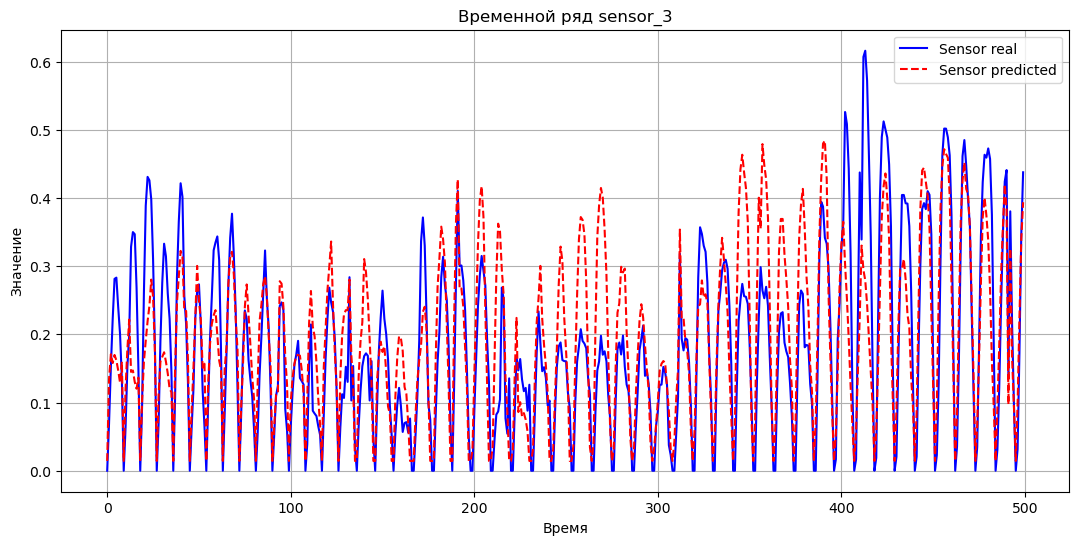

In [78]:
# –ü—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ—Ç—Å—è, —á—Ç–æ df ‚Äî —ç—Ç–æ –≤–∞—à DataFrame
plt.figure(figsize=(13, 6))  # –£—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º —Ä–∞–∑–º–µ—Ä –≥—Ä–∞—Ñ–∏–∫–∞
plt.plot(df['sensor_3'].iloc[:500], linestyle='-', color='blue', label='Sensor real')
plt.plot(df_dec['sensor_3'].iloc[:500], linestyle='--', color='red', label='Sensor predicted')  # –õ–∏–Ω–∏—è –≥—Ä–∞—Ñ–∏–∫–∞
plt.title('–í—Ä–µ–º–µ–Ω–Ω–æ–π —Ä—è–¥ sensor_3')  # –ó–∞–≥–æ–ª–æ–≤–æ–∫ –≥—Ä–∞—Ñ–∏–∫–∞
plt.xlabel('–í—Ä–µ–º—è')  # –ü–æ–¥–ø–∏—Å—å –æ—Å–∏ X
plt.ylabel('–ó–Ω–∞—á–µ–Ω–∏–µ')  # –ü–æ–¥–ø–∏—Å—å –æ—Å–∏ Y
plt.legend()  # –õ–µ–≥–µ–Ω–¥–∞
plt.grid(True)  # –°–µ—Ç–∫–∞
plt.show()  # –û—Ç–æ–±—Ä–∞–∂–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–∞

### Plain

In [79]:
compressed_main = lz4.frame.compress(main_sensor.tobytes())
decompressed_main = np.frombuffer(lz4.frame.decompress(compressed_main), dtype=np.float32)
assert np.allclose(main_sensor, decompressed_main), "–û—à–∏–±–∫–∞ –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏—è –≥–ª–∞–≤–Ω–æ–≥–æ —Å–µ–Ω—Å–æ—Ä–∞!"


In [80]:
compressed_main

b'\x04"M\x18h@\xecS\x00\x00\x00\x00\x00\x00lc>\x00\x00\xf0\x15\x00\x00\x00\x00\xad\x9a\xf0=\x90m*>N\xcf\x17>\xed\xfe(>\xd9\x89\x1d>R\x0e\x08>\x98%\xe5=\x94\xac\x1a>$\x00\xf1\x00\xb4\x18\xd1=\xa4\xe25>\x98%e>\r1\x05 \x00@\xdd\x02\xe8=\x18\x00@7U\xf6=$\x0012\xdc\xab0\x00\xf1\x08[\xc6B>SHb>\xc1\x0f|>\t\xf2\x94>_\xe8\x85>w\xb9.H\x00\xb1\xd1\x0b\xbd=\xbc\xeb\x1a>\x05\xb3$\x14\x00\x00`\x00@\xc8S\x02>H\x001\xa0\xa3\xc5H\x00\xf1\x08:Z\x0c>&\xe5\x80>N\xcf\x97>\xc8\xc7\xab>J\x90\xa7>\xf2ws\x04\x00\x00\x9c\x00\x00l\x00\xf1\x04\xc4\x14\x92=\xdd\xc8\r>"\xe0j>o\x1e\xa1>\xc8S\x82\x9c\x00\x00\x14\x001\xac`\x16l\x00\xf1\x08\x0ek\xdf=\xd1\x0b=>k\xfc]>\xc5Nl>\x94\xe6t>\xcd\xccL\xe0\x001\xf7$\t$\x00\xf1\x10\x97\xeb\n>\xe9\xbf8>"\xa6\x90>\x9cG\xa8>\xe1$\xab>\xf1=\x99>;\x94f>\x01t4$\x00@\xd9\x89\x9d=T\x001\x1e\xa1z(\x00@g\xbdm>X\x00q|2\xf9=\xbc\x96\xb1\xb4\x00\x00\x0c\x01\x00\xf4\x00qd~}>])\x91\xbc\x00\x00\xf8\x00q\x88\xefI>g\x83\x13H\x00\xf1\x04\xfa\xf5S=\x94\xbd\xbd=\x16\xe9\xbf=g\x83\x93>s]\x91T\x00q\xa8

In [81]:
from tensorflow.keras.layers import Conv1D, Flatten, Reshape

X = main_sensor.reshape(-1, 1)  # –í—Ö–æ–¥ –∞–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä–∞
Y = dependent_sensors   

input_dim = 1  # –í—Ö–æ–¥: –≥–ª–∞–≤–Ω—ã–π —Å–µ–Ω—Å–æ—Ä
output_dim = Y.shape[1]  # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∑–∞–≤–∏—Å–∏–º—ã—Ö —Å–µ–Ω—Å–æ—Ä–æ–≤

inputs = Input(shape=(input_dim, 1))  # –î–æ–±–∞–≤–ª—è–µ–º —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å –¥–ª—è Conv1D

# –°–≤–µ—Ä—Ç–æ—á–Ω—ã–π –±–ª–æ–∫
x = Conv1D(16, kernel_size=3, activation='relu', padding='same')(inputs)
x = Flatten()(x)

# –°–∂–∞—Ç–∏–µ
encoded = Dense(input_dim, activation='relu')(x)  # –ü—Ä–∏–≤–æ–¥–∏–º –∫ —Ü–µ–ª–µ–≤–æ–π —Ñ–æ—Ä–º–µ –¥–ª—è Reshape

# –í–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏–µ
x = Dense(input_dim * 16, activation='relu')(encoded)  # –†–∞—Å—à–∏—Ä—è–µ–º –æ–±—Ä–∞—Ç–Ω–æ –¥–ª—è Conv1D
x = Reshape((input_dim, 16))(x)  # –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤ (input_dim, 16)
decoded = Conv1D(output_dim, kernel_size=3, activation='linear', padding='same')(x)

# –ê–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä
autoencoder = keras.Model(inputs, decoded)
autoencoder.compile(optimizer='rmsprop', loss='mse')

# –û–±—É—á–µ–Ω–∏–µ
autoencoder.fit(X.reshape(-1, 1, 1), Y.reshape(-1, 1, output_dim), epochs=30, batch_size=32, shuffle=True, verbose=1)

# –ö–æ–¥–∏—Ä–æ–≤—â–∏–∫
encoder = keras.Model(inputs, encoded)


Epoch 1/30
168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 3ms/step - loss: 0.0382
Epoch 2/30
168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0087
Epoch 3/30
168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0081
Epoch 4/30
168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0081
Epoch 5/30
168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - loss: 0.0080
Epoch 6/30
168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0082
Epoch 7/30
168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0079
Epoch 8/30
168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0081
Epoch 9/30
168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0080
Epoch 10/30
168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

KeyboardInterrupt: 

In [ ]:
# # –í—Ö–æ–¥: –≥–ª–∞–≤–Ω—ã–π —Å–µ–Ω—Å–æ—Ä (X), –í—ã—Ö–æ–¥: –∑–∞–≤–∏—Å–∏–º—ã–µ —Å–µ–Ω—Å–æ—Ä—ã (Y)
# X = main_sensor.reshape(-1, 1)  # –í—Ö–æ–¥ –∞–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä–∞
# Y = dependent_sensors           # –í—ã—Ö–æ–¥ –∞–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä–∞

# # –°–æ–∑–¥–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏ –∞–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä–∞
# input_dim = 1
# output_dim = Y.shape[1]

# inputs = Input(shape=(input_dim,))
# encoded = Dense(8, activation='relu')(inputs)
# encoded = Dense(4, activation='relu')(encoded)

# decoded = Dense(8, activation='relu')(encoded)
# decoded = Dense(output_dim, activation='sigmoid')(decoded)  # –í—ã—Ö–æ–¥ –≤ –¥–∏–∞–ø–∞–∑–æ–Ω–µ [0,1]

# autoencoder = keras.Model(inputs, decoded)
# autoencoder.compile(optimizer='adam', loss='mse')

# # –û–±—É—á–µ–Ω–∏–µ –∞–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä–∞
# autoencoder.fit(X, Y, epochs=20, batch_size=32, shuffle=True, verbose=1)

# # –í—ã–¥–µ–ª—è–µ–º –∫–æ–¥–∏—Ä–æ–≤—â–∏–∫
# encoder = keras.Model(inputs, encoded)


In [ ]:
compressed_dependent = encoder.predict(X)


168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 447us/step


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# –í—Ö–æ–¥ –¥–ª—è –¥–µ–∫–æ–¥–µ—Ä–∞
decoder_input = Input(shape=(input_dim,))  # –í—Ö–æ–¥–Ω–æ–µ —Å–∂–∞—Ç–æ–µ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏–µ

# –í–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏–µ —á–µ—Ä–µ–∑ —Å–ª–æ–∏ –∞–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä–∞
decoder_layer1 = autoencoder.layers[-3](decoder_input)  # Dense —Å–ª–æ–π –¥–ª—è –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏—è
decoder_layer2 = autoencoder.layers[-2](decoder_layer1)  # Reshape —Å–ª–æ–π
decoder_layer3 = autoencoder.layers[-1](decoder_layer2)  # Conv1D —Å–ª–æ–π

# –°–æ–∑–¥–∞–µ–º –º–æ–¥–µ–ª—å –¥–µ–∫–æ–¥–µ—Ä–∞
decoder = Model(decoder_input, decoder_layer3)

# –ò—Å–ø–æ–ª—å–∑—É–µ–º –¥–µ–∫–æ–¥–µ—Ä –¥–ª—è –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏—è –∑–∞–≤–∏—Å–∏–º—ã—Ö —Å–µ–Ω—Å–æ—Ä–æ–≤
restored_dependent = decoder.predict(compressed_dependent)

168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 389us/step


In [ ]:
# decoder_input = Input(shape=(4,))
# decoder_layer1 = autoencoder.layers[-2](decoder_input)
# decoder_layer2 = autoencoder.layers[-1](decoder_layer1)
# decoder = keras.Model(decoder_input, decoder_layer2)

# restored_dependent = decoder.predict(compressed_dependent)



In [ ]:
# –ò—Å—Ö–æ–¥–Ω—ã–π —Ä–∞–∑–º–µ—Ä (–±–∞–π—Ç—ã)
original_main_size = main_sensor.nbytes
original_dependent_size = dependent_sensors.nbytes
original_total_size = original_main_size + original_dependent_size

# –°–∂–∞—Ç—ã–π —Ä–∞–∑–º–µ—Ä (–±–∞–π—Ç—ã)
compressed_main_size = len(compressed_main)
compressed_dependent_size = compressed_dependent.nbytes
compressed_total_size = compressed_main_size + compressed_dependent_size

# –í—ã–≤–æ–¥ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
print(f"üîπ –ò—Å—Ö–æ–¥–Ω—ã–π —Ä–∞–∑–º–µ—Ä –¥–∞–Ω–Ω—ã—Ö: {original_total_size / 1024:.2f} KB")
print(f"üîπ –°–∂–∞—Ç—ã–π —Ä–∞–∑–º–µ—Ä –¥–∞–Ω–Ω—ã—Ö: {compressed_total_size / 1024:.2f} KB")
print(f"‚ö° –°—Ç–µ–ø–µ–Ω—å —Å–∂–∞—Ç–∏—è: {original_total_size / compressed_total_size:.2f}x")

# # –†–∞–∑–º–µ—Ä LZ4-—Å–∂–∞—Ç–æ–≥–æ –≥–ª–∞–≤–Ω–æ–≥–æ —Å–µ–Ω—Å–æ—Ä–∞
# compressed_main_size = len(compressed_main)

# # –†–∞–∑–º–µ—Ä –∫–æ–¥–∏—Ä–æ–≤–∞–Ω–Ω–æ–≥–æ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏—è –∑–∞–≤–∏—Å–∏–º—ã—Ö —Å–µ–Ω—Å–æ—Ä–æ–≤
# compressed_dependent_size = compressed_dependent.nbytes

# # –û–±—â–∏–π —Ä–∞–∑–º–µ—Ä –ø–æ—Å–ª–µ —Å–∂–∞—Ç–∏—è
# compressed_total_size = compressed_main_size + compressed_dependent_size

# print(f"üîπ –°–∂–∞—Ç—ã–π —Ä–∞–∑–º–µ—Ä –¥–∞–Ω–Ω—ã—Ö: {compressed_total_size / 1024:.2f} KB")

üîπ –ò—Å—Ö–æ–¥–Ω—ã–π —Ä–∞–∑–º–µ—Ä –¥–∞–Ω–Ω—ã—Ö: 83.92 KB
üîπ –°–∂–∞—Ç—ã–π —Ä–∞–∑–º–µ—Ä –¥–∞–Ω–Ω—ã—Ö: 36.60 KB
‚ö° –°—Ç–µ–ø–µ–Ω—å —Å–∂–∞—Ç–∏—è: 2.29x


In [ ]:
restored = [x[0] for x in restored_dependent]
restored

[array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20

In [ ]:
df_dec = pd.DataFrame(restored)
df_dec.columns = ['sensor_3', 'sensor_4', 'sensor_5']
df_dec

sensor_3  sensor_4  sensor_5
0     0.223763  0.206813  0.166038
1     0.223763  0.206813  0.166038
2     0.223763  0.206813  0.166038
3     0.223763  0.206813  0.166038
4     0.223763  0.206813  0.166038
...        ...       ...       ...
5366  0.223763  0.206813  0.166038
5367  0.223763  0.206813  0.166038
5368  0.223763  0.206813  0.166038
5369  0.223763  0.206813  0.166038
5370  0.223763  0.206813  0.166038

[5371 rows x 3 columns]

In [ ]:
print('RMSE:', rmse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MSE:', mse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MAE:', mae(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Total error:', total_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Column error:\n', column_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))

RMSE: 0.049
MSE: 0.002
MAE: 0.00877091953345921
Total error: 1120.075057185583
Column error:
 sensor_3    416.006291
sensor_4    351.012284
sensor_5    353.056483
dtype: float64


In [ ]:
import os
decoder.save("decoder.h5")
with open("decoder.h5", "rb") as f_in:
    compressed_data = lz4.frame.compress(f_in.read())
    with open("decoder.h5.lz4", "wb") as f_out:
        f_out.write(compressed_data)
original_size = os.path.getsize("decoder.h5")
compressed_size = os.path.getsize("decoder.h5.lz4")

In [ ]:
print(f"–†–∞–∑–º–µ—Ä –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–æ–≥–æ —Ñ–∞–π–ª–∞: {original_size} –±–∞–π—Ç")
print(f"–†–∞–∑–º–µ—Ä —Å–∂–∞—Ç–æ–≥–æ —Ñ–∞–π–ª–∞: {compressed_size} –±–∞–π—Ç")

–†–∞–∑–º–µ—Ä –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–æ–≥–æ —Ñ–∞–π–ª–∞: 16016 –±–∞–π—Ç
–†–∞–∑–º–µ—Ä —Å–∂–∞—Ç–æ–≥–æ —Ñ–∞–π–ª–∞: 2531 –±–∞–π—Ç


### DWT

In [ ]:
import numpy as np
import pandas as pd
import pywt
import lz4.frame
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, Reshape, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
def apply_dwt(data, wavelet='haar', level=1):
    """–ü—Ä–∏–º–µ–Ω—è–µ—Ç DWT –∏ –æ—Å—Ç–∞–≤–ª—è–µ—Ç —Ç–æ–ª—å–∫–æ –Ω–∏–∑–∫–æ—á–∞—Å—Ç–æ—Ç–Ω—ã–µ –∫–æ–º–ø–æ–Ω–µ–Ω—Ç—ã."""
    coeffs = pywt.wavedec(data, wavelet, level=level)
    return coeffs[0]  # –ë–µ—Ä–µ–º —Ç–æ–ª—å–∫–æ –ø—Ä–∏–±–ª–∏–∂–µ–Ω–Ω—ã–µ –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç—ã

def apply_idwt(approx, wavelet='haar', level=1, original_length=1000):
    """–í–æ—Å—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ—Ç —Å–∏–≥–Ω–∞–ª —á–µ—Ä–µ–∑ IDWT, –¥–æ–±–∞–≤–ª—è—è –Ω—É–ª–µ–≤—ã–µ –≤—ã—Å–æ–∫–æ—á–∞—Å—Ç–æ—Ç–Ω—ã–µ –∫–æ–º–ø–æ–Ω–µ–Ω—Ç—ã."""
    coeffs = [approx] + [np.zeros_like(approx)] * level  # –ù—É–ª–µ–≤—ã–µ –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç—ã –¥–ª—è –¥–µ—Ç–∞–ª–µ–π
    restored = pywt.waverec(coeffs, wavelet)[:original_length]  # –í–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏–µ
    return restored


In [ ]:
# –ì–ª–∞–≤–Ω—ã–π —Å–µ–Ω—Å–æ—Ä (–ø–µ—Ä–≤—ã–π —Å—Ç–æ–ª–±–µ—Ü)
main_sensor = df.iloc[:, 0].values.astype(np.float32)

# –û—Å—Ç–∞–ª—å–Ω—ã–µ —Å–µ–Ω—Å–æ—Ä—ã (–≤—Å–µ –∫—Ä–æ–º–µ –ø–µ—Ä–≤–æ–≥–æ)
dependent_sensors = df.iloc[:, 1:].values.astype(np.float32)

In [ ]:
def compress_main_sensor(data):
    return lz4.frame.compress(data.tobytes())

def decompress_main_sensor(compressed_data, dtype=np.float32):
    return np.frombuffer(lz4.frame.decompress(compressed_data), dtype=dtype)

compressed_main = compress_main_sensor(main_sensor)
decompressed_main = decompress_main_sensor(compressed_main)


In [ ]:
# –†–∞–∑–ª–æ–∂–µ–Ω–∏–µ –∑–∞–≤–∏—Å–∏–º—ã—Ö —Å–µ–Ω—Å–æ—Ä–æ–≤ —á–µ—Ä–µ–∑ DWT
X_dwt = np.array([apply_dwt(sensor) for sensor in dependent_sensors.T]).T  # –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –ø–æ –∫–æ–ª–æ–Ω–∫–∞–º
# –û–±—Ä–µ–∑–∞–µ–º –≥–ª–∞–≤–Ω—ã–π —Å–µ–Ω—Å–æ—Ä –¥–æ —Ä–∞–∑–º–µ—Ä–∞ DWT-–∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–æ–≤
X_resized = main_sensor[:X_dwt.shape[0]]


In [ ]:
X = main_sensor.reshape(-1, 1)  # –ì–ª–∞–≤–Ω—ã–π —Å–µ–Ω—Å–æ—Ä (1D –≤—Ö–æ–¥)
Y = X_dwt  # DWT-–∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç—ã –∑–∞–≤–∏—Å–∏–º—ã—Ö —Å–µ–Ω—Å–æ—Ä–æ–≤

# –û–ø—Ä–µ–¥–µ–ª—è–µ–º –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—É –∞–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä–∞
input_dim = 1
output_dim = Y.shape[1]

inputs = Input(shape=(input_dim, 1))  # Conv1D —Ç—Ä–µ–±—É–µ—Ç 3D –≤—Ö–æ–¥

# –°–≤–µ—Ä—Ç–æ—á–Ω—ã–π –±–ª–æ–∫
x = Conv1D(16, kernel_size=3, activation='relu', padding='same')(inputs)
x = GlobalAveragePooling1D()(x)  # –í–º–µ—Å—Ç–æ Flatten()

# –°–∂–∞—Ç–∏–µ (–ª–∞—Ç–µ–Ω—Ç–Ω–æ–µ –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–æ)
encoded = Dense(16, activation='relu')(x)

# –í–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏–µ
x = Dense(output_dim, activation='relu')(encoded)  # –í–æ—Å—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å
decoded = Reshape((1, output_dim))(x)  # –¢–µ–ø–µ—Ä—å –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ
decoded = Conv1D(output_dim, kernel_size=3, activation='linear', padding='same')(decoded)

# –°–æ–∑–¥–∞–µ–º –∞–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä
autoencoder = keras.Model(inputs, decoded)
autoencoder.compile(optimizer='rmsprop', loss='mse')

# –û–±—É—á–µ–Ω–∏–µ –∞–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä–∞
autoencoder.fit(X_resized.reshape(-1, 1, 1), X_dwt.reshape(-1, 1, X_dwt.shape[1]), epochs=30, batch_size=32, shuffle=True, verbose=1)
encoder = keras.Model(inputs, encoded)


Epoch 1/30
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 884us/step - loss: 0.1095
Epoch 2/30
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 799us/step - loss: 0.0666
Epoch 3/30
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 689us/step - loss: 0.0663
Epoch 4/30
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 772us/step - loss: 0.0642
Epoch 5/30
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 659us/step - loss: 0.0643
Epoch 6/30
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 639us/step - loss: 0.0653
Epoch 7/30
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 736us/step - loss: 0.0632
Epoch 8/30
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 671us/step - loss: 0.0648
Epoch 9/30
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - loss: 0.0636
Epoch 10/30
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

In [ ]:
def compress_dependent_sensors(encoder, main_sensor):
    return encoder.predict(main_sensor.reshape(-1, 1, 1))

compressed_dependent = compress_dependent_sensors(encoder, main_sensor)


168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 783us/step


In [ ]:
# –î–µ–∫–æ–¥–µ—Ä (–≤–æ—Å—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ—Ç –∑–∞–≤–∏—Å–∏–º—ã–µ —Å–µ–Ω—Å–æ—Ä—ã)
decoder_input = Input(shape=(16,))
decoder_layer1 = autoencoder.layers[-3](decoder_input)
decoder_layer2 = autoencoder.layers[-2](decoder_layer1)
decoder_layer3 = autoencoder.layers[-1](decoder_layer2)
decoder = keras.Model(decoder_input, decoder_layer3)

# –í–æ—Å—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç—ã DWT
restored_dwt_coeffs = decoder.predict(compressed_dependent)

# –í–æ—Å—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º —Å–∏–≥–Ω–∞–ª—ã —á–µ—Ä–µ–∑ IDWT
restored_dependent_dwt = np.array([apply_idwt(sensor) for sensor in restored_dwt_coeffs.T]).T


168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 414us/step


In [ ]:
# –†–∞–∑–º–µ—Ä –∏—Å—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö
original_main_size = main_sensor.nbytes
original_dependent_size = dependent_sensors.nbytes
original_total_size = original_main_size + original_dependent_size

# –†–∞–∑–º–µ—Ä —Å–∂–∞—Ç—ã—Ö –¥–∞–Ω–Ω—ã—Ö
compressed_main_size = len(compressed_main)
compressed_dependent_size = compressed_dependent.nbytes
compressed_total_size = compressed_main_size + compressed_dependent_size

# –í—ã–≤–æ–¥ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
print(f"üîπ –ò—Å—Ö–æ–¥–Ω—ã–π —Ä–∞–∑–º–µ—Ä –¥–∞–Ω–Ω—ã—Ö: {original_total_size / 1024:.2f} KB")
print(f"üîπ –°–∂–∞—Ç—ã–π —Ä–∞–∑–º–µ—Ä –¥–∞–Ω–Ω—ã—Ö: {compressed_total_size / 1024:.2f} KB")
print(f"‚ö° –°—Ç–µ–ø–µ–Ω—å —Å–∂–∞—Ç–∏—è: {original_total_size / compressed_total_size:.2f}x")


üîπ –ò—Å—Ö–æ–¥–Ω—ã–π —Ä–∞–∑–º–µ—Ä –¥–∞–Ω–Ω—ã—Ö: 83.92 KB
üîπ –°–∂–∞—Ç—ã–π —Ä–∞–∑–º–µ—Ä –¥–∞–Ω–Ω—ã—Ö: 351.31 KB
‚ö° –°—Ç–µ–ø–µ–Ω—å —Å–∂–∞—Ç–∏—è: 0.24x


In [ ]:
restored_dependent_dwt

array([[[0.20728295, 0.19977416, 0.1588426 ]],

       [[0.20728295, 0.19977416, 0.1588426 ]],

       [[0.20975184, 0.20329612, 0.15983318]],

       ...,

       [[0.21162695, 0.20426567, 0.15974496]],

       [[0.21097696, 0.20463477, 0.16012311]],

       [[0.21097696, 0.20463477, 0.16012311]]], dtype=float32)

In [ ]:
restored = [x[0] for x in restored_dependent_dwt]
df_dec = pd.DataFrame(restored)
df_dec.columns = ['sensor_3', 'sensor_4', 'sensor_5']
df_dec
print('RMSE:', rmse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MSE:', mse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MAE:', mae(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Total error:', total_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Column error:\n', column_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))

RMSE: nan
MSE: nan
MAE: 0.0339345378539108
Total error: 2444.566530634019
Column error:
 sensor_3    833.758304
sensor_4    912.161224
sensor_5    698.647003
dtype: float64


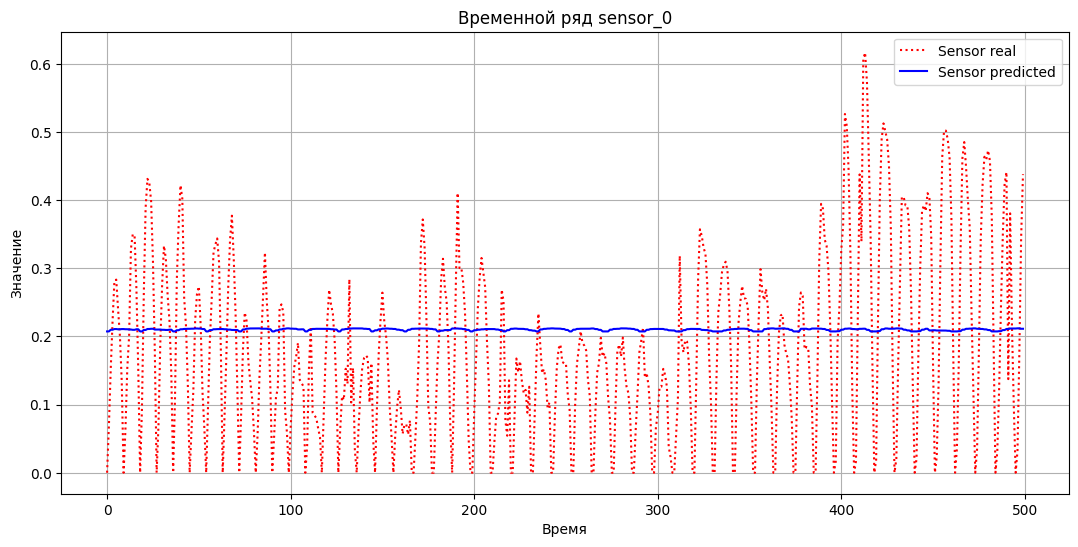

In [ ]:
# –ü—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ—Ç—Å—è, —á—Ç–æ df ‚Äî —ç—Ç–æ –≤–∞—à DataFrame
plt.figure(figsize=(13, 6))  # –£—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º —Ä–∞–∑–º–µ—Ä –≥—Ä–∞—Ñ–∏–∫–∞
plt.plot(df['sensor_3'].iloc[:500], linestyle='dotted', color='red', label='Sensor real')
plt.plot(df_dec['sensor_3'].iloc[:500], linestyle='-', color='blue', label='Sensor predicted')  # –õ–∏–Ω–∏—è –≥—Ä–∞—Ñ–∏–∫–∞
plt.title('–í—Ä–µ–º–µ–Ω–Ω–æ–π —Ä—è–¥ sensor_0')  # –ó–∞–≥–æ–ª–æ–≤–æ–∫ –≥—Ä–∞—Ñ–∏–∫–∞
plt.xlabel('–í—Ä–µ–º—è')  # –ü–æ–¥–ø–∏—Å—å –æ—Å–∏ X
plt.ylabel('–ó–Ω–∞—á–µ–Ω–∏–µ')  # –ü–æ–¥–ø–∏—Å—å –æ—Å–∏ Y
plt.legend()  # –õ–µ–≥–µ–Ω–¥–∞
plt.grid(True)  # –°–µ—Ç–∫–∞
plt.show()  # –û—Ç–æ–±—Ä–∞–∂–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–∞

## New

In [ ]:
import numpy as np
import pywt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Ä–∞–∑–ª–æ–∂–µ–Ω–∏—è —Ä—è–¥–∞ —Å –ø–æ–º–æ—â—å—é DWT
def apply_dwt(data, wavelet='haar', level=1):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    return coeffs[0]  # –ë–µ—Ä–µ–º —Ç–æ–ª—å–∫–æ –Ω–∏–∑–∫–æ—á–∞—Å—Ç–æ—Ç–Ω—ã–µ –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç—ã

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏—è —á–µ—Ä–µ–∑ IDWT
def apply_idwt(approx, wavelet='haar', level=1, original_length=1000):
    coeffs = [approx] + [np.zeros_like(approx)] * level
    restored = pywt.waverec(coeffs, wavelet)[:original_length]
    return restored

# –ì–ª–∞–≤–Ω—ã–π —Å–µ–Ω—Å–æ—Ä (–ø–µ—Ä–≤—ã–π —Å—Ç–æ–ª–±–µ—Ü)
main_sensor = df.iloc[:, 0].values.astype(np.float32)

# –û—Å—Ç–∞–ª—å–Ω—ã–µ —Å–µ–Ω—Å–æ—Ä—ã (–≤—Å–µ –∫—Ä–æ–º–µ –ø–µ—Ä–≤–æ–≥–æ)
dependent_sensors = df.iloc[:, 1:].values.astype(np.float32)

# –†–∞–∑–ª–æ–∂–µ–Ω–∏–µ –∑–∞–≤–∏—Å–∏–º—ã—Ö —Å–µ–Ω—Å–æ—Ä–æ–≤ —á–µ—Ä–µ–∑ DWT
level = 1
X_dwt = np.array([apply_dwt(sensor, level=level) for sensor in dependent_sensors.T]).T  

# –û–±—Ä–µ–∑–∞–µ–º –≥–ª–∞–≤–Ω—ã–π —Å–µ–Ω—Å–æ—Ä –¥–æ —Ä–∞–∑–º–µ—Ä–∞ DWT-–∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–æ–≤
X_resized = main_sensor[:X_dwt.shape[0]].reshape(-1, 1)

# –°–æ–∑–¥–∞–µ–º –∞–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä —Å LSTM
timesteps = X_resized.shape[0]
input_dim = 1
output_dim = X_dwt.shape[1]

inputs = Input(shape=(input_dim, 1))
x = LSTM(32, activation='relu', return_sequences=False)(inputs)
x = Dense(16, activation='relu')(x)
encoded = Dense(8, activation='relu')(x)

# –î–µ–∫–æ–¥–µ—Ä
x = Dense(16, activation='relu')(encoded)
x = RepeatVector(input_dim)(x)
x = LSTM(32, activation='relu', return_sequences=True)(x)
decoded = TimeDistributed(Dense(output_dim, activation='linear'))(x)

autoencoder = keras.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# –û–±—É—á–µ–Ω–∏–µ –∞–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä–∞
autoencoder.fit(X_resized.reshape(-1, 1, 1), X_dwt.reshape(-1, 1, output_dim),
                epochs=50, batch_size=32, shuffle=True, verbose=1)

# –ö–æ–¥–∏—Ä–æ–≤—â–∏–∫
encoder = keras.Model(inputs, encoded)


Epoch 1/50
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1ms/step - loss: 0.1250
Epoch 2/50
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - loss: 0.0637
Epoch 3/50
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - loss: 0.0656  
Epoch 4/50
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - loss: 0.0652  
Epoch 5/50
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - loss: 0.0638  
Epoch 6/50
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - loss: 0.0674  
Epoch 7/50
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - loss: 0.0638  
Epoch 8/50
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 965us/step - loss: 0.0663
Epoch 9/50
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 987us/step - loss: 0.0615
Epoch 10/50
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

In [ ]:
# –°–∂–∞—Ç–∏–µ –∑–∞–≤–∏—Å–∏–º—ã—Ö —Å–µ–Ω—Å–æ—Ä–æ–≤ —á–µ—Ä–µ–∑ –∞–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä
compressed_dependent = encoder.predict(X_resized.reshape(-1, 1, 1))


84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 468us/step


In [ ]:
decoder_input = Input(shape=(8,))
# Add a Dense layer to expand the input to the expected shape
expanded_input = Dense(16, activation='relu')(decoder_input)
decoder_layer1 = autoencoder.layers[-5](expanded_input)
decoder_layer2 = autoencoder.layers[-4](decoder_layer1)
decoder_layer3 = autoencoder.layers[-3](decoder_layer2)
decoder_layer4 = autoencoder.layers[-2](decoder_layer3)
decoder_layer5 = autoencoder.layers[-1](decoder_layer4)
decoder = keras.Model(decoder_input, decoder_layer5)
# –í–æ—Å—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º DWT-–∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç—ã
restored_dwt_coeffs = decoder.predict(compressed_dependent)

# –í–æ—Å—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º —Å–∏–≥–Ω–∞–ª—ã —á–µ—Ä–µ–∑ IDWT
restored_dependent_dwt = np.array([apply_idwt(sensor) for sensor in restored_dwt_coeffs.T]).T

84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step


In [ ]:
restored = [x[0] for x in restored_dependent_dwt]
df_dec = pd.DataFrame(restored)
df_dec.columns = ['sensor_3', 'sensor_4', 'sensor_5']
df_dec
print('RMSE:', rmse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MSE:', mse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MAE:', mae(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Total error:', total_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Column error:\n', column_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))

RMSE: nan
MSE: nan
MAE: 0.0338086769411208
Total error: 2462.360859185891
Column error:
 sensor_3    839.080863
sensor_4    915.302333
sensor_5    707.977664
dtype: float64


In [ ]:

# –î–µ–∫–æ–¥–µ—Ä (–≤–æ—Å—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ—Ç –∑–∞–≤–∏—Å–∏–º—ã–µ —Å–µ–Ω—Å–æ—Ä—ã)
decoder_input = Input(shape=(8,))
decoder_layer1 = autoencoder.layers[-5](decoder_input)
decoder_layer2 = autoencoder.layers[-4](decoder_layer1)
decoder_layer3 = autoencoder.layers[-3](decoder_layer2)
decoder_layer4 = autoencoder.layers[-2](decoder_layer3)
decoder_layer5 = autoencoder.layers[-1](decoder_layer4)
decoder = keras.Model(decoder_input, decoder_layer5)

# –í–æ—Å—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º DWT-–∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç—ã
restored_dwt_coeffs = decoder.predict(compressed_dependent)

# –í–æ—Å—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º —Å–∏–≥–Ω–∞–ª—ã —á–µ—Ä–µ–∑ IDWT
restored_dependent_dwt = np.array([apply_idwt(sensor) for sensor in restored_dwt_coeffs.T]).T

ValueError: Input 0 of layer "dense_9" is incompatible with the layer: expected axis -1 of input shape to have value 16, but received input with shape (None, 8)

## LSTM

In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, RepeatVector, TimeDistributed
# from tensorflow.keras.models import Model

# # –§–æ—Ä–º–∏—Ä—É–µ–º –¥–∞–Ω–Ω—ã–µ
# main_sensor = df.iloc[:, 0].values.reshape(-1, 1)  # –ì–ª–∞–≤–Ω—ã–π —Å–µ–Ω—Å–æ—Ä
# dependent_sensors = df.iloc[:, 1:].values  # –û—Å—Ç–∞–ª—å–Ω—ã–µ —Å–µ–Ω—Å–æ—Ä—ã
# timesteps = main_sensor.shape[0]  # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—Ä–µ–º–µ–Ω–Ω—ã—Ö —à–∞–≥–æ–≤
# output_dim = dependent_sensors.shape[1]  # –ß–∏—Å–ª–æ –∑–∞–≤–∏—Å–∏–º—ã—Ö —Å–µ–Ω—Å–æ—Ä–æ–≤

# # –°–æ–∑–¥–∞–Ω–∏–µ –∞–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä–∞
# input_layer = Input(shape=(timesteps, 1))  # (batch, timesteps, channels)

# # –≠–Ω–∫–æ–¥–µ—Ä
# x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_layer)
# x = LSTM(16, activation='relu', return_sequences=False)(x)  # –°–∂–∏–º–∞–µ–º –≤—Ä–µ–º–µ–Ω–Ω—ã–µ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏
# encoded = Dense(16, activation='relu')(x)  # –ö–æ–¥–∏—Ä–æ–≤–∫–∞

# # –î–µ–∫–æ–¥–µ—Ä
# x = RepeatVector(timesteps)(encoded)  # –†–∞–∑–≤–æ—Ä–∞—á–∏–≤–∞–µ–º –æ–±—Ä–∞—Ç–Ω–æ
# x = LSTM(16, activation='relu', return_sequences=True)(x)
# x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)
# decoded = TimeDistributed(Dense(output_dim))(x)  # –í—ã—Ö–æ–¥–Ω–æ–µ –∏–∑–º–µ—Ä–µ–Ω–∏–µ = —á–∏—Å–ª—É –∑–∞–≤–∏—Å–∏–º—ã—Ö —Å–µ–Ω—Å–æ—Ä–æ–≤

# # –°–æ–∑–¥–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏
# autoencoder = Model(input_layer, decoded)
# autoencoder.compile(optimizer='adam', loss='mse')

# # –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
# autoencoder.fit(main_sensor.reshape(1, timesteps, 1), 
#                 dependent_sensors.reshape(1, timesteps, output_dim), 
#                 epochs=50, batch_size=1, shuffle=False, verbose=1)

# # –ö–æ–¥–∏—Ä–æ–≤—â–∏–∫
# encoder = Model(input_layer, encoded)

# # –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Å–∂–∞—Ç–∏—è
# def compress_dependent_sensors(encoder, main_sensor):
#     return encoder.predict(main_sensor.reshape(1, timesteps, 1))

# compressed_dependent = compress_dependent_sensors(encoder, main_sensor)

# # –î–µ–∫–æ–¥–µ—Ä (–≤–æ—Å—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ—Ç –∑–∞–≤–∏—Å–∏–º—ã–µ —Å–µ–Ω—Å–æ—Ä—ã)
# decoder_input = Input(shape=(16,))
# x = RepeatVector(timesteps)(decoder_input)
# x = autoencoder.layers[-3](x)
# x = autoencoder.layers[-2](x)
# decoder_output = autoencoder.layers[-1](x)
# decoder = Model(decoder_input, decoder_output)

# # –í–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏–µ –∑–∞–≤–∏—Å–∏–º—ã—Ö —Å–µ–Ω—Å–æ—Ä–æ–≤
# restored_dependent = decoder.predict(compressed_dependent)


Epoch 1/50


In [ ]:
df1 = df.iloc[:1000]

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Reshape
from tensorflow.keras.models import Model

# –§–æ—Ä–º–∏—Ä—É–µ–º –¥–∞–Ω–Ω—ã–µ
main_sensor = df1.iloc[:, 0].values.reshape(-1, 1)  # –ì–ª–∞–≤–Ω—ã–π —Å–µ–Ω—Å–æ—Ä
dependent_sensors = df1.iloc[:, 1:].values  # –û—Å—Ç–∞–ª—å–Ω—ã–µ —Å–µ–Ω—Å–æ—Ä—ã
timesteps = main_sensor.shape[0]  # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—Ä–µ–º–µ–Ω–Ω—ã—Ö —à–∞–≥–æ–≤
output_dim = dependent_sensors.shape[1]  # –ß–∏—Å–ª–æ –∑–∞–≤–∏—Å–∏–º—ã—Ö —Å–µ–Ω—Å–æ—Ä–æ–≤

# –í—Ö–æ–¥–Ω–æ–π —Å–ª–æ–π
input_layer = Input(shape=(timesteps, 1))  # (batch, timesteps, channels)

# –≠–Ω–∫–æ–¥–µ—Ä: —É–±–∏—Ä–∞–µ–º —Ä–∞–∑—Ä–µ–∂–µ–Ω–Ω–æ—Å—Ç—å
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_layer)
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
x = Flatten()(x)
encoded = Dense(32, activation='relu')(x)  # –õ–∞—Ç–µ–Ω—Ç–Ω–æ–µ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏–µ

# –î–µ–∫–æ–¥–µ—Ä
x = Dense(timesteps * 32, activation='relu')(encoded)
x = Reshape((timesteps, 32))(x)
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
decoded = Conv1D(output_dim, kernel_size=3, activation='linear', padding='same')(x)  # –í–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–Ω—ã–µ —Ä—è–¥—ã

# –°–æ–∑–¥–∞–µ–º –∞–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
autoencoder.fit(main_sensor.reshape(1, timesteps, 1), 
                dependent_sensors.reshape(1, timesteps, output_dim), 
                epochs=50, batch_size=8, shuffle=False, verbose=1)

# –ö–æ–¥–∏—Ä–æ–≤—â–∏–∫
encoder = Model(input_layer, encoded)

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Å–∂–∞—Ç–∏—è
def compress_dependent_sensors(encoder, main_sensor):
    return encoder.predict(main_sensor.reshape(1, timesteps, 1))

compressed_dependent = compress_dependent_sensors(encoder, main_sensor)

# –î–µ–∫–æ–¥–µ—Ä
decoder_input = Input(shape=(32,))
x = Dense(timesteps * 32, activation='relu')(decoder_input)
x = Reshape((timesteps, 32))(x)
x = autoencoder.layers[-2](x)
decoder_output = autoencoder.layers[-1](x)
decoder = Model(decoder_input, decoder_output)

# –í–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏–µ –∑–∞–≤–∏—Å–∏–º—ã—Ö —Å–µ–Ω—Å–æ—Ä–æ–≤
restored_dependent = decoder.predict(compressed_dependent)


Epoch 1/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 676ms/step - loss: 0.0533
Epoch 2/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 28ms/step - loss: 0.0478
Epoch 3/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 28ms/step - loss: 0.0355
Epoch 4/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 41ms/step - loss: 0.0194
Epoch 5/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 25ms/step - loss: 0.0150
Epoch 6/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 27ms/step - loss: 0.0132
Epoch 7/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 26ms/step - loss: 0.0051
Epoch 8/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 33ms/step - loss: 0.0026
Epoch 9/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 26ms/step - loss: 0.0033
Epoch 10/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

In [ ]:
len(restored_dependent)

1

In [ ]:
df_dec = pd.DataFrame(restored_dependent[0])
df_dec.columns = ['sensor_3', 'sensor_4', 'sensor_5']
df_dec
print('RMSE:', rmse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']].iloc[:1000], df_dec))
print('MSE:', mse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']].iloc[:1000], df_dec))
print('MAE:', mae(df_wind[['sensor_3', 'sensor_4', 'sensor_5']].iloc[:1000], df_dec))
print('Total error:', total_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']].iloc[:1000], df_dec))
print('Column error:\n', column_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']].iloc[:1000], df_dec))

RMSE: 0.086
MSE: 0.007
MAE: 0.03293343254458161
Total error: 391.53223657866056
Column error:
 sensor_3    148.936025
sensor_4    136.996147
sensor_5    105.600065
dtype: float64


## Trans

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Flatten, Reshape
from tensorflow.keras.models import Model

# –î–∞–Ω–Ω—ã–µ
main_sensor = df.iloc[:, 0].values.reshape(-1, 1)  # –ì–ª–∞–≤–Ω—ã–π —Å–µ–Ω—Å–æ—Ä
dependent_sensors = df.iloc[:, 1:].values  # –û—Å—Ç–∞–ª—å–Ω—ã–µ —Å–µ–Ω—Å–æ—Ä—ã
timesteps = main_sensor.shape[0]  # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—Ä–µ–º–µ–Ω–Ω—ã—Ö —à–∞–≥–æ–≤
output_dim = dependent_sensors.shape[1]  # –ß–∏—Å–ª–æ –∑–∞–≤–∏—Å–∏–º—ã—Ö —Å–µ–Ω—Å–æ—Ä–æ–≤

# === Self-Attention –±–ª–æ–∫ ===
def transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs  # Skip connection

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res  # –ï—â–µ –æ–¥–∏–Ω Skip connection

# === –ê–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä ===
input_layer = Input(shape=(timesteps, 1))  # –í—Ö–æ–¥: –≥–ª–∞–≤–Ω—ã–π —Å–µ–Ω—Å–æ—Ä

# === –≠–Ω–∫–æ–¥–µ—Ä ===
x = transformer_encoder(input_layer, head_size=64, num_heads=4, ff_dim=128)
x = Flatten()(x)
encoded = Dense(32, activation='relu')(x)  # –°–∂–∞—Ç–æ–µ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏–µ

# === –î–µ–∫–æ–¥–µ—Ä ===
x = Dense(timesteps * 32, activation='relu')(encoded)
x = Reshape((timesteps, 32))(x)
decoded = Dense(output_dim, activation='linear')(x)  # –í–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–Ω—ã–µ —Å–µ–Ω—Å–æ—Ä—ã

# === –ö–æ–º–ø–∏–ª—è—Ü–∏—è –º–æ–¥–µ–ª–∏ ===
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# === –û–±—É—á–µ–Ω–∏–µ ===
autoencoder.fit(main_sensor.reshape(1, timesteps, 1), 
                dependent_sensors.reshape(1, timesteps, output_dim), 
                epochs=50, batch_size=1, shuffle=False, verbose=1)

# === –ö–æ–¥–∏—Ä–æ–≤—â–∏–∫ ===
encoder = Model(input_layer, encoded)

# === –§—É–Ω–∫—Ü–∏—è —Å–∂–∞—Ç–∏—è ===
def compress_dependent_sensors(encoder, main_sensor):
    return encoder.predict(main_sensor.reshape(1, timesteps, 1))

compressed_dependent = compress_dependent_sensors(encoder, main_sensor)

# === –î–µ–∫–æ–¥–µ—Ä ===
decoder_input = Input(shape=(32,))
x = Dense(timesteps * 32, activation='relu')(decoder_input)
x = Reshape((timesteps, 32))(x)
decoder_output = autoencoder.layers[-1](x)
decoder = Model(decoder_input, decoder_output)

# === –í–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏–µ –∑–∞–≤–∏—Å–∏–º—ã—Ö —Å–µ–Ω—Å–æ—Ä–æ–≤ ===
restored_dependent = decoder.predict(compressed_dependent)


Epoch 1/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step - loss: 0.0757
Epoch 2/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 645ms/step - loss: 0.0748
Epoch 3/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 600ms/step - loss: 0.0739
Epoch 4/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 612ms/step - loss: 0.0726
Epoch 5/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 595ms/step - loss: 0.0708
Epoch 6/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 625ms/step - loss: 0.0680
Epoch 7/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 653ms/step - loss: 0.0642
Epoch 8/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 728ms/step - loss: 0.0595
Epoch 9/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 662ms/step - loss: 0.0538
Epoch 10/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

In [ ]:
restored_dependent

array([[[ 0.056105  , -0.04311186,  0.04697923],
        [-0.02958975,  0.00418208,  0.04870737],
        [ 0.10758165,  0.0018437 ,  0.00375578],
        ...,
        [ 0.08784125,  0.00056764,  0.07029693],
        [ 0.02005295,  0.04333524,  0.10955424],
        [ 0.08194717, -0.00742864,  0.041898  ]]], dtype=float32)

In [ ]:
df_dec = pd.DataFrame(restored_dependent[0])
df_dec.columns = ['sensor_3', 'sensor_4', 'sensor_5']
df_dec
print('RMSE:', rmse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MSE:', mse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MAE:', mae(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Total error:', total_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Column error:\n', column_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))

RMSE: 0.133
MSE: 0.018
MAE: 0.07077302404571108
Total error: 3166.2825707763595
Column error:
 sensor_3    1106.702196
sensor_4    1224.378157
sensor_5     835.202218
dtype: float64


## TSN

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Reshape, Add, Activation, LayerNormalization
from tensorflow.keras.models import Model

# === –ü–∞—Ä–∞–º–µ—Ç—Ä—ã ===
timesteps = main_sensor.shape[0]  # –î–ª–∏–Ω–∞ –≤—Ä–µ–º–µ–Ω–Ω–æ–≥–æ —Ä—è–¥–∞
output_dim = dependent_sensors.shape[1]  # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∑–∞–≤–∏—Å–∏–º—ã—Ö —Å–µ–Ω—Å–æ—Ä–æ–≤
latent_dim = 16  # –†–∞–∑–º–µ—Ä —Å–∫—Ä—ã—Ç–æ–≥–æ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏—è

# === TCN –ë–ª–æ–∫ ===
def tcn_block(x, filters, kernel_size, dilation_rate):
    skip = x
    if x.shape[-1] != filters:  # Adjust input shape if necessary
        skip = Conv1D(filters, kernel_size=1, padding="same")(x)
    x = Conv1D(filters, kernel_size, padding="same", dilation_rate=dilation_rate, activation="relu")(x)
    x = Conv1D(filters, kernel_size, padding="same", dilation_rate=dilation_rate)(x)
    x = Add()([x, skip])  # Residual connection
    x = Activation("relu")(x)
    x = LayerNormalization()(x)
    return x

# === –≠–Ω–∫–æ–¥–µ—Ä ===
input_layer = Input(shape=(timesteps, 1))
x = tcn_block(input_layer, 32, 3, dilation_rate=1)
x = tcn_block(x, 32, 3, dilation_rate=2)  # Ensure consistent filter size
x = tcn_block(x, 32, 3, dilation_rate=4)  # Ensure consistent filter size
x = Flatten()(x)
encoded = Dense(latent_dim, activation="relu")(x)  # –õ–∞—Ç–µ–Ω—Ç–Ω–æ–µ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏–µ

# === –î–µ–∫–æ–¥–µ—Ä ===
x = Dense(timesteps * latent_dim, activation="relu")(encoded)
x = Reshape((timesteps, latent_dim))(x)
x = Conv1D(64, 3, padding="same", activation="relu")(x)
decoded = Conv1D(output_dim, 3, padding="same", activation="linear")(x)  # –í–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ

# === –°–æ–∑–¥–∞–µ–º –º–æ–¥–µ–ª—å ===
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

# === –û–±—É—á–µ–Ω–∏–µ ===
autoencoder.fit(main_sensor.reshape(1, timesteps, 1), 
                dependent_sensors.reshape(1, timesteps, output_dim), 
                epochs=50, batch_size=1, verbose=1)

# === –ö–æ–¥–∏—Ä–æ–≤—â–∏–∫ ===
encoder = Model(input_layer, encoded)

# === –î–µ–∫–æ–¥–µ—Ä ===
decoder_input = Input(shape=(latent_dim,))
x = Dense(timesteps * latent_dim, activation="relu")(decoder_input)
x = Reshape((timesteps, latent_dim))(x)
x = autoencoder.layers[-2](x)
decoder_output = autoencoder.layers[-1](x)
decoder = Model(decoder_input, decoder_output)

# === –°–∂–∞—Ç–∏–µ –∏ –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏–µ ===
compressed_dependent = encoder.predict(main_sensor.reshape(1, timesteps, 1))
restored_dependent = decoder.predict(compressed_dependent)


Epoch 1/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step - loss: 0.0753
Epoch 2/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 41ms/step - loss: 0.1951
Epoch 3/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 37ms/step - loss: 0.0730
Epoch 4/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 47ms/step - loss: 0.0719
Epoch 5/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 39ms/step - loss: 0.0706
Epoch 6/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 49ms/step - loss: 0.0650
Epoch 7/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 38ms/step - loss: 0.0597
Epoch 8/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 40ms/step - loss: 0.0501
Epoch 9/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 37ms/step - loss: 0.0382
Epoch 10/50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

In [ ]:
restored_dependent

array([[[ 0.01297282,  0.0678226 , -0.11363906],
        [-0.02993756,  0.23898853,  0.11824781],
        [ 0.18738009,  0.26095995,  0.10083752],
        ...,
        [ 0.13488671,  0.17390661,  0.24043901],
        [ 0.174104  ,  0.10839196,  0.07400285],
        [ 0.11624812,  0.05801732,  0.12616135]]], dtype=float32)

In [ ]:
df_dec = pd.DataFrame(restored_dependent[0])
df_dec.columns = ['sensor_3', 'sensor_4', 'sensor_5']
df_dec
print('RMSE:', rmse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MSE:', mse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MAE:', mae(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Total error:', total_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Column error:\n', column_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))

RMSE: 0.135
MSE: 0.018
MAE: 0.04185965000186915
Total error: 2611.6890063024557
Column error:
 sensor_3    906.466116
sensor_4    957.031164
sensor_5    748.191727
dtype: float64


## SZ3

In [76]:
import numpy as np
from pathlib import Path
import sys
import pandas as pd
from sz.SZ3.tools.pysz.pysz import SZ

In [110]:
data = df.values.transpose()

In [111]:
df

sensor_0  sensor_3  sensor_4  sensor_5
0     0.000000  0.000000  0.000000  0.000000
1     0.117483  0.068950  0.069215  0.019261
2     0.166434  0.152344  0.127238  0.069999
3     0.148252  0.222754  0.135462  0.106351
4     0.165035  0.281452  0.207547  0.159913
...        ...       ...       ...       ...
5366  0.412587  0.190855  0.240445  0.093544
5367  0.381818  0.235148  0.203423  0.093049
5368  0.345455  0.213067  0.163038  0.086803
5369  0.296032  0.159991  0.130950  0.079433
5370  0.197203  0.123203  0.075955  0.049847

[5371 rows x 4 columns]

In [112]:
get_float_bytes(df)

–†–∞–∑–º–µ—Ä –∏—Å—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö: 1374976 –±–∏—Ç
–†–∞–∑–º–µ—Ä –∏—Å—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö: 171872 –±–∞–π—Ç 



In [113]:
data

array([[0.        , 0.11748252, 0.16643357, ..., 0.34545455, 0.29603168,
        0.1972028 ],
       [0.        , 0.06894999, 0.15234413, ..., 0.21306746, 0.15999051,
        0.12320271],
       [0.        , 0.06921519, 0.12723754, ..., 0.16303822, 0.13094975,
        0.07595549],
       [0.        , 0.01926123, 0.06999891, ..., 0.08680267, 0.07943277,
        0.04984707]])

In [114]:
lib_extension = {
    "darwin": "libSZ3c.dylib",  # macOS
    "win32": "SZ3c.dll",  # Windows
}.get(sys.platform, "libSZ3c.so")  # Linux (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é)
lib_extension

'libSZ3c.dylib'

In [115]:
sz = SZ(f"/usr/local/lib/{lib_extension}")

In [121]:
mem = 0
data_dec = []
for d in data:
    data_cmpr, cmpr_ratio = sz.compress(d, eb_mode=0, eb_pwr=0, eb_rel=0, eb_abs=0.03)
    print(data_cmpr.nbytes)
    data_dec.append(sz.decompress(data_cmpr, d.shape, d.dtype))
    mem += data_cmpr.nbytes
    print(mean_squared_error(d, sz.decompress(data_cmpr, d.shape, d.dtype)))
print(mem)

2082
0.0002766918524623217
2145
0.00026444352170291183
2129
0.00027273231822622947
1867
0.00028175398323767334
8223


In [172]:
print(round(mean_squared_error(data, data_dec), 6))

3e-05


In [88]:
data_cmpr, cmpr_ratio = sz.compress(data, eb_mode=0, eb_pwr=0, eb_rel=0, eb_abs=0.01)
print(f"Compression ratio: {cmpr_ratio}")

Compression ratio: 14.752961373390558


In [89]:
len(data_cmpr)

11650

In [192]:
size_in_bytes = data_cmpr.nbytes
print(f"–û–±—ä–µ–º –º–∞—Å—Å–∏–≤–∞: {size_in_bytes} –±–∞–π—Ç")

–û–±—ä–µ–º –º–∞—Å—Å–∏–≤–∞: 25525 –±–∞–π—Ç


In [157]:
data_dec = sz.decompress(data_cmpr, data.shape, data.dtype)
sz.verify(data, data_dec)

abs err=0.001


(0.0009999999999999731, 62.95910839584953, 0.0007112865232694253)

In [148]:
mean_squared_error(data_dec, data)

3.1730034353751545e-07

## SZ + Conv

In [174]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Reshape, LSTM, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler

In [90]:
#best
df = df_wind[['sensor_0', 'sensor_3', 'sensor_4', 'sensor_5']].copy()
# –í—ã–±–∏—Ä–∞–µ–º –≥–ª–∞–≤–Ω—ã–π —Å–µ–Ω—Å–æ—Ä (–ø–µ—Ä–≤—ã–π —Å—Ç–æ–ª–±–µ—Ü)
main_sensor = df.iloc[:, 0].values.astype(np.float32)

# –í—ã–±–∏—Ä–∞–µ–º –∑–∞–≤–∏—Å–∏–º—ã–µ —Å–µ–Ω—Å–æ—Ä—ã (–≤—Å–µ –∫—Ä–æ–º–µ –ø–µ—Ä–≤–æ–≥–æ —Å—Ç–æ–ª–±—Ü–∞)
dependent_sensors = df.iloc[:, 1:].values.astype(np.float32)
window_size = 10

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Ä–∞–∑–±–∏–µ–Ω–∏—è –Ω–∞ –æ–∫–Ω–∞
def create_windows(data, window_size):
    return np.array([data[i:i+window_size] for i in range(len(data) - window_size)])

X = create_windows(main_sensor.reshape(-1, 1), window_size)  # –¢–æ–ª—å–∫–æ –≥–ª–∞–≤–Ω—ã–π —Å–µ–Ω—Å–æ—Ä
Y = create_windows(df.values, window_size)  # –í–æ—Å—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º –≤—Å–µ —Å–µ–Ω—Å–æ—Ä—ã

X = X.reshape(X.shape[0], X.shape[1], 1)  # (samples, time_steps, 1)
Y = Y.reshape(Y.shape[0], Y.shape[1], Y.shape[2])  # (samples, time_steps, 4)

input_dim = window_size
output_dim = Y.shape[2]  # 4 —Å–µ–Ω—Å–æ—Ä–∞
encoding_dim = 2  # –†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å —Å–∂–∞—Ç–æ–≥–æ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏—è

# –ê—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞ –∞–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä–∞
inputs = Input(shape=(input_dim, 1))
x = Conv1D(4, kernel_size=3, activation='selu', padding='same')(inputs)  # –£–º–µ–Ω—å—à–∏–ª–∏ —á–∏—Å–ª–æ —Ñ–∏–ª—å—Ç—Ä–æ–≤
x = Flatten()(x)
encoded = Dense(encoding_dim, activation='selu', name="bottleneck")(x)  # –ö–æ–¥–∏—Ä—É–µ–º X

# –î–µ–∫–æ–¥–µ—Ä (–≤–æ—Å—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º –≤—Å–µ 4 —Å–µ–Ω—Å–æ—Ä–∞)
x = Dense(input_dim * output_dim, activation='selu')(encoded)
x = Reshape((input_dim, output_dim))(x)
decoded = Conv1D(output_dim, kernel_size=3, activation='selu', padding='same')(x)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# –û–±—É—á–µ–Ω–∏–µ
autoencoder.fit(X, Y, shuffle=True, epochs=30, batch_size=4, verbose=1)

# –ö–æ–¥–∏—Ä–æ–≤—â–∏–∫ (—Å–∂–∞—Ç–∏–µ X)
encoder = Model(inputs, encoded)

# –î–µ–∫–æ–¥–µ—Ä (–≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏–µ –≤—Å–µ—Ö —Å–µ–Ω—Å–æ—Ä–æ–≤)
encoded_input = Input(shape=(encoding_dim,))
x = Dense(input_dim * output_dim, activation='selu')(encoded_input)
x = Reshape((input_dim, output_dim))(x)
decoded_output = Conv1D(output_dim, kernel_size=3, activation='selu', padding='same')(x)
decoder = Model(encoded_input, decoded_output)

Epoch 1/30
1341/1341 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 2ms/step - loss: 0.0399
Epoch 2/30
1341/1341 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2ms/step - loss: 0.0104
Epoch 3/30
1341/1341 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 2ms/step - loss: 0.0100
Epoch 4/30
1341/1341 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 4ms/step - loss: 0.0101
Epoch 5/30
1341/1341 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 2ms/step - loss: 0.0099
Epoch 6/30
1341/1341 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 2ms/step - loss: 0.0099
Epoch 7/30
1341/1341 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 3ms/step - loss: 0.0098
Epoch 8/30
1341/1341 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 2ms/step - loss: 0.0098
Epoch 9/30
1341/1341 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 2ms/step - loss: 0.0097
Epoch 10/30
1341/13

KeyboardInterrupt: 

In [176]:
#save dec+enc
encoder.save("encoder.h5")
with open("encoder.h5", "rb") as f_in:
    compressed_encoder = lz4.frame.compress(f_in.read())
print('enc:', len(compressed_decoder))
decoder.save("decoder.h5")
with open("decoder.h5", "rb") as f_in:
    compressed_decoder = lz4.frame.compress(f_in.read())
print('dec:', len(compressed_decoder))
compressed_main = lz4.frame.compress(main_sensor.tobytes())
decompressed_main = np.frombuffer(lz4.frame.decompress(compressed_main), dtype=np.float32)
print('main:', len(compressed_main))

enc: 2747
dec: 3029
main: 15994


In [188]:
# –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –≤–µ—Å–æ–≤ –≤ –º–∞—Å—Å–∏–≤
encoder_weights = encoder.get_weights()
encoder_weights_array = np.array(encoder_weights, dtype=object) 
encoder_weights_array

array([array([[[-0.33191064, -0.30232286, -0.5340995 ,  0.5274248 ]],

              [[-0.38706186,  0.3315786 ,  0.31514454,  0.24630095]],

              [[-0.07153147,  0.15053287, -0.3647175 ,  0.5064364 ]]],
             dtype=float32)                                           ,
       array([ 0.22103126,  0.05046909,  0.1176609 , -0.20115551], dtype=float32),
       array([[-0.15745485, -0.43245798],
              [-0.31407136,  0.0280147 ],
              [ 0.17412205,  0.3119225 ],
              [-0.19097805, -0.28732586],
              [-0.2513313 , -0.04832087],
              [-0.33873984,  0.36948976],
              [ 0.13785815, -0.33138472],
              [ 0.48601326, -0.12093212],
              [ 0.3238593 , -0.49083778],
              [ 0.0178881 , -0.31792188],
              [ 0.01297161, -0.6240355 ],
              [ 0.26549485, -0.21140721],
              [ 0.03836635,  0.09955379],
              [-0.07286333,  0.2957399 ],
              [ 0.393307  , -0.37294447],
  

In [189]:
encoder_weights_array[0]

array([[[-0.33191064, -0.30232286, -0.5340995 ,  0.5274248 ]],

       [[-0.38706186,  0.3315786 ,  0.31514454,  0.24630095]],

       [[-0.07153147,  0.15053287, -0.3647175 ,  0.5064364 ]]],
      dtype=float32)

In [ ]:
# –í–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏–µ –≤–µ—Å–æ–≤
reconstructed_encoder.set_weights(encoder_weights_array.tolist())

### Best

In [101]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, SeparableConv1D
from tensorflow.keras.models import Model
import lz4.frame
X = main_sensor.reshape(-1, 1)  # –í—Ö–æ–¥ –∞–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä–∞
Y = dependent_sensors
# –ì–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä—ã
window_size = 64
X_windows = []
Y_targets = []
output_dim = Y.shape[1]
for i in range(len(X) - window_size):
    X_windows.append(X[i:i+window_size])
    Y_targets.append(Y[i+window_size]) 

X_windows = np.array(X_windows).reshape(-1, window_size, 1)
Y_targets = np.array(Y_targets).reshape(-1, output_dim)

X_windows = np.array(X_windows).reshape(-1, window_size, 1)
Y_targets = np.array(Y_targets).reshape(-1, output_dim)
output_dim = Y.shape[1]

inputs = Input(shape=(window_size, 1))
x = SeparableConv1D(2, kernel_size=3, activation='selu', padding='same')(inputs)  # –ì–ª—É–±–∏–Ω–Ω–∞—è —Å–≤—ë—Ä—Ç–∫–∞
x = Flatten()(x)
x = Dense(4, activation='selu')(x)  
outputs = Dense(output_dim, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')

model.fit(X_windows, Y_targets, epochs=50, batch_size=64, verbose=1)

preds = model.predict(X_windows)
for i in range(output_dim):
    rmse = mean_squared_error(Y_targets[:, i], preds[:, i])
    print(f"RMSE sen_{i+3}: {rmse:.6f}")

Epoch 1/50
83/83 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 3ms/step - loss: 0.1011
Epoch 2/50
83/83 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0394
Epoch 3/50
83/83 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - loss: 0.0323
Epoch 4/50
83/83 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - loss: 0.0277
Epoch 5/50
83/83 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0220
Epoch 6/50
83/83 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0183
Epoch 7/50
83/83 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - loss: 0.0155
Epoch 8/50
83/83 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 5ms/step - loss: 0.0143
Epoch 9/50
83/83 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - loss: 0.0133
Epoch 10/50
83/83 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

In [102]:
# –°–æ—Ö—Ä–∞–Ω—è–µ–º –º–æ–¥–µ–ª—å –≤ —Ñ–æ—Ä–º–∞—Ç–µ SavedModel
model.export("saved_model")  # –°–æ—Ö—Ä–∞–Ω—è–µ—Ç—Å—è –≤ –ø–∞–ø–∫—É

# –ó–∞–≥—Ä—É–∂–∞–µ–º –∏ –∫–æ–Ω–≤–µ—Ä—Ç–∏—Ä—É–µ–º –≤ tflite
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
#converter.target_spec.supported_types = [tf.float32]  # –ë–µ–∑ –∫–≤–∞–Ω—Ç–∏–∑–∞—Ü–∏–∏
tflite_model = converter.convert()

# –°–æ—Ö—Ä–∞–Ω—è–µ–º tflite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 1), dtype=tf.float32, name='keras_tensor_17')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  5647641488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5647640080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5647641664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5644468288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5644469168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5644468816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5690167664: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1743864414.226572 9228190 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1743864414.226627 9228190 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2025-04-05 17:46:54.227037: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model
2025-04-05 17:46:54.228116: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-04-05 17:46:54.228134: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: saved_model
2025-04-05 17:46:54.245404: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2025-04-05 17:46:54.300712: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: saved_model
2025-04-05 17:46:54.329536: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 102533 microseconds.


In [103]:
import lz4.frame

# –ß—Ç–µ–Ω–∏–µ –∏ —Å–∂–∞—Ç–∏–µ –º–æ–¥–µ–ª–∏
with open("model.tflite", "rb") as f:
    tflite_bytes = f.read()
    compressed_model = lz4.frame.compress(tflite_bytes)

# –°–æ—Ö—Ä–∞–Ω—è–µ–º —Å–∂–∞—Ç—É—é –º–æ–¥–µ–ª—å
with open("model.tflite.lz4", "wb") as f:
    f.write(compressed_model)

print(f"üì¶ –†–∞–∑–º–µ—Ä –ø–æ—Å–ª–µ —Å–∂–∞—Ç–∏—è: {len(compressed_model)} –±–∞–π—Ç")

üì¶ –†–∞–∑–º–µ—Ä –ø–æ—Å–ª–µ —Å–∂–∞—Ç–∏—è: 5353 –±–∞–π—Ç


In [104]:
# –†–∞—Å–ø–∞–∫–æ–≤–∫–∞ –æ–±—Ä–∞—Ç–Ω–æ
with open("model.tflite.lz4", "rb") as f:
    compressed_data = f.read()
    decompressed_tflite = lz4.frame.decompress(compressed_data)

# –ó–∞–≥—Ä—É–∑–∫–∞ –≤ TFLite-–∏–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∞—Ç–æ—Ä
interpreter = tf.lite.Interpreter(model_content=decompressed_tflite)
interpreter.allocate_tensors()

# –ü–æ–ª—É—á–µ–Ω–∏–µ –∏–Ω—Ñ–æ
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [105]:
restored_Y = []

for i in range(len(X_windows)):
    input_tensor = X_windows[i:i+1].astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    restored_Y.append(output[0])

restored_Y = np.array(restored_Y)

In [109]:
for i in range(output_dim):
    rmse = mean_squared_error(Y[window_size:, i], restored_Y[:, i])
    print(f"MSE sen_{i+3}: {rmse:.6f}")

MSE sen_3: 0.010364
MSE sen_4: 0.010174
MSE sen_5: 0.007140
